In [1]:
import os
print(os.getcwd())

C:\Program Files\Microsoft VS Code


In [2]:
import os

# Change to your project directory (update the path as needed)
os.chdir(r"H:\Work_With_MZ\LC_Classification_Code")

# Verify the change
print(os.getcwd())

H:\Work_With_MZ\LC_Classification_Code


In [3]:
# Import libraries
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import folium
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [24]:
# Trigger the authentication flow
ee.Authenticate()

True

In [25]:
# Initialize the library
ee.Initialize()

In [7]:
# Initializes the Google Earth Engine API
geemap.ee_initialize()

In [1]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import folium
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Point, Polygon
from shapely.validation import make_valid
import json
from shapely.geometry import mapping
from shapely import geometry

# 1. Authentication and Initialization
def initialize_earth_engine():
    """Initialize Earth Engine with robust error handling."""
    try:
        ee.Initialize()
        print("Earth Engine initialized successfully.")
        return True
    except Exception as e:
        print(f"Initial attempt to initialize Earth Engine failed: {e}")
        print("Attempting to authenticate...")
        try:
            ee.Authenticate()
            ee.Initialize()
            print("Earth Engine authenticated and initialized successfully.")
            return True
        except Exception as auth_e:
            print(f"Authentication failed: {auth_e}")
            print("Please ensure you have an active Google Earth Engine account and valid credentials.")
            print("Run `earthengine authenticate` in a terminal or follow the browser prompts.")
            return False

if not initialize_earth_engine():
    print("Earth Engine initialization failed. Exiting.")
    exit()

# 2. Load the study area boundary and water observation data
study_area_path = "Province_Sofian/Export_Output.shp"
water_areas_path = "Pools_Observation/Pools.shp"

try:
    study_area_gdf = gpd.read_file(study_area_path)
    water_areas_gdf = gpd.read_file(water_areas_path)
except Exception as e:
    print(f"Error loading shapefiles: {e}")
    print("Please ensure the file paths are correct and shapefiles are valid.")
    exit()

study_area_gdf = study_area_gdf.to_crs(epsg=4326)
water_areas_gdf = water_areas_gdf.to_crs(epsg=4326)

def remove_z_coordinate(geom):
    """Convert 3D geometry to 2D by removing z-coordinate."""
    if geom is None:
        return None
    if geom.has_z:
        if geom.geom_type == 'Polygon':
            coords = [list(coord)[0:2] for coord in geom.exterior.coords]
            return Polygon(coords)
        elif geom.geom_type == 'MultiPolygon':
            polygons = []
            for poly in geom.geoms:
                coords = [list(coord)[0:2] for coord in poly.exterior.coords]
                polygons.append(Polygon(coords))
            return geometry.MultiPolygon(polygons)
    return geom

print("Converting 3D geometries to 2D...")
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(remove_z_coordinate)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(remove_z_coordinate)

print("Validating and cleaning geometries...")
invalid_geometries = water_areas_gdf[~water_areas_gdf.geometry.is_valid]
empty_geometries = water_areas_gdf[water_areas_gdf.geometry.is_empty]
print(f"Invalid geometries in water_areas_gdf: {len(invalid_geometries)}")
print(f"Empty geometries in water_areas_gdf: {len(empty_geometries)}")

water_areas_gdf = water_areas_gdf[water_areas_gdf.geometry.is_valid & ~water_areas_gdf.geometry.is_empty]
print(f"Number of features in water_areas_gdf after cleaning: {len(water_areas_gdf)}")
print(f"Geometry types in water_areas_gdf: {water_areas_gdf.geometry.type.unique()}")

water_areas_gdf['geometry'] = water_areas_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
water_areas_gdf = water_areas_gdf.explode(index_parts=True).reset_index(drop=True)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(make_valid)

invalid_geometries_study = study_area_gdf[~study_area_gdf.geometry.is_valid]
empty_geometries_study = study_area_gdf[study_area_gdf.geometry.is_empty]
print(f"Invalid geometries in study_area_gdf: {len(invalid_geometries_study)}")
print(f"Empty geometries in study_area_gdf: {len(empty_geometries_study)}")
study_area_gdf = study_area_gdf[study_area_gdf.geometry.is_valid & ~study_area_gdf.geometry.is_empty]
study_area_gdf['geometry'] = study_area_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(make_valid)
print(f"Number of features in study_area_gdf after cleaning: {len(study_area_gdf)}")

center_point = study_area_gdf.geometry.unary_union.centroid
map_center = [center_point.y, center_point.x]
print(f"The center point of your study area is: Latitude={map_center[0]:.4f}, Longitude={map_center[1]:.4f}")

try:
    roi = geemap.gdf_to_ee(study_area_gdf)
    print("Successfully converted study_area_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting study_area_gdf to EE FeatureCollection: {e}")
    temp_geojson = "temp_study_area.geojson"
    try:
        study_area_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        roi = ee.FeatureCollection(geojson_data)
        print("Manually converted study_area_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual conversion of study_area_gdf failed: {e}")
        print("Sample study_area_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

water_polygons_ee = None
try:
    water_polygons_ee = geemap.gdf_to_ee(water_areas_gdf)
    print("Successfully converted water_areas_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting water_areas_gdf to EE FeatureCollection: {e}")
    print("Attempting manual GeoJSON conversion...")
    temp_geojson = "temp_water_areas.geojson"
    try:
        water_areas_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        water_polygons_ee = ee.FeatureCollection(geojson_data)
        print("Manually converted water_areas_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual GeoJSON conversion failed: {e}")
        print("Sample water_areas_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

if water_polygons_ee is None:
    print("Error: water_polygons_ee could not be created. Exiting.")
    exit()

# 3. Data Downloading and Processing
start_date = "2023-01-01"
end_date = "2023-12-31"

def s2Process(dates, extent, cloud):
    try:
        start_date, end_date = dates
        def imgDownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                        .filterDate(start_date, end_date)
                        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud))
                        .filterBounds(extent))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-2 Images")
            if size == 0:
                raise Exception("No Sentinel-2 images found for the specified date range and region.")
            return img_collection
        
        def s2ClearSky(image):
            scl = image.select('SCL')
            clear_sky_pixels = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6)).Or(scl.eq(11))
            return image.updateMask(clear_sky_pixels).multiply(0.0001)
        
        def bandResample(image):
            bands_10m = image.select(["B2", "B3", "B4", "B8"])
            bands_20m = image.select(["B11"]).resample("bilinear").reproject(crs=bands_10m.projection(), scale=10)
            return bands_10m.addBands(bands_20m)

        def indices(image):
            ndvi = image.normalizedDifference(["B8", "B4"]).rename("ndvi")
            mndwi = image.normalizedDifference(["B3", "B11"]).rename("mndwi")
            return image.addBands([ndvi, mndwi])
        
        s2_collection = imgDownload()
        s2_collection_resampled = (s2_collection
                               .map(s2ClearSky)
                               .map(bandResample)
                               .map(indices))
        s2_median = s2_collection_resampled.median().clip(extent)
        
        print(f"The bands in s2_median are: {s2_median.bandNames().getInfo()}")
        return s2_median
    except Exception as e:
        print(f"Error in Sentinel-2 processing: {e}")
        raise

def s1Process(dates, extent, radius):
    try:
        start_date, end_date = dates
        def imgdownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
                    .filterDate(start_date, end_date)
                    .filter(ee.Filter.eq("instrumentMode", "IW"))
                    .filterMetadata("resolution_meters", "equals", 10)
                    .filterBounds(extent)
                    .select(["VV", "VH"]))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-1 Images")
            if size == 0:
                raise Exception("No Sentinel-1 images found for the specified date range and region.")
            return img_collection

        def speckle(image):
            image_filtered = image.focal_median(radius, "circle", "meters")
            return image_filtered.copyProperties(image, image.propertyNames())
        
        def ratio(image):
            vh = image.select("VH")
            vv = image.select("VV")
            ratio = vh.divide(vv).rename("VH_VV_ratio")
            return image.addBands([ratio])

        s1_collection = imgdownload()
        s1_collection_filtered = (s1_collection
                                  .map(speckle)
                                  .map(ratio))
        s1_median = s1_collection_filtered.median().clip(extent)
        
        print(f"The bands in s1_median are: {s1_median.bandNames().getInfo()}")
        return s1_median
    except Exception as e:
        print(f"Error in Sentinel-1 processing: {e}")
        raise

try:
    s2_median_2023 = s2Process(dates=(start_date, end_date), extent=roi, cloud=50)  # Increased cloud cover threshold
    s1_median_2023 = s1Process(dates=(start_date, end_date), extent=roi, radius=50)
    stacked_layer = s2_median_2023.select(['ndvi', 'mndwi']).addBands(s1_median_2023.select(['VH', 'VV', 'VH_VV_ratio']))
    print(f"The bands in the stacked layer are: {stacked_layer.bandNames().getInfo()}")
except Exception as e:
    print(f"Error processing Sentinel images: {e}")
    exit()

# 4. Generate Training and Testing Samples
def generate_non_water_samples(roi, water_polygons, num_points):
    """Generate random non-water points within ROI but outside water polygons."""
    try:
        points = ee.FeatureCollection([])
        while points.size().getInfo() < num_points:
            random_points = ee.FeatureCollection.randomPoints(
                region=roi.geometry(), 
                points=num_points, 
                seed=np.random.randint(1, 100000)
            )
            non_water_points = random_points.filter(ee.Filter.geometry(water_polygons.geometry().dissolve()).Not())
            non_water_points_classified = non_water_points.map(lambda f: f.set('Class', 0))
            points = points.merge(non_water_points_classified)
        return points.limit(num_points)
    except Exception as e:
        print(f"Error generating non-water samples: {e}")
        raise

num_samples = 1000  # Increased to 1000 per class

try:
    water_samples = water_polygons_ee.map(lambda f: f.set('Class', 1)).randomColumn('random').limit(num_samples)
    print(f"Water samples created (labeled as 1): {water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error assigning class to water samples: {e}")
    exit()

try:
    non_water_samples = generate_non_water_samples(roi, water_polygons_ee, num_samples)
    print(f"Non-water samples created (labeled as 0): {non_water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error generating non-water samples: {e}")
    exit()

try:
    combined_samples = water_samples.merge(non_water_samples)
    print(f"Total training samples created: {combined_samples.size().getInfo()}")
except Exception as e:
    print(f"Error combining samples: {e}")
    exit()

def trainTest(sample, image, threshold):
    try:
        sample_random = sample.randomColumn("random")
        training_set_features = sample_random.filter(ee.Filter.lt("random", threshold))
        testing_set_features = sample_random.filter(ee.Filter.gte("random", threshold))
        
        def sample_point(feature):
            class_value = feature.get('Class')
            sampled_values = image.reduceRegion(
                reducer=ee.Reducer.first(),
                geometry=feature.geometry(),
                scale=20  # Increased scale to reduce null values
            )
            return ee.Feature(None, sampled_values).set('Class', class_value)

        training = training_set_features.map(sample_point)
        testing = testing_set_features.map(sample_point)

        print(f"Training set size: {training.size().getInfo()}")
        print(f"Testing set size: {testing.size().getInfo()}")

        return training, testing
    except Exception as e:
        print(f"Error splitting training/testing sets: {e}")
        raise

def filter_invalid_samples(feature_collection, band_names, class_property='Class'):
    all_properties_to_check = band_names + [class_property]
    combined_filter = ee.Filter.And(
        [ee.Filter.notNull([prop]) for prop in all_properties_to_check]
    )
    filtered = feature_collection.filter(combined_filter)
    counts = filtered.aggregate_histogram(class_property).getInfo()
    print(f"Class distribution after filtering: {counts}")
    if len(counts) < 2:
        raise ValueError(f"Filtered dataset contains only one class: {counts}")
    return filtered

try:
    training, testing = trainTest(combined_samples, stacked_layer, 0.7)
    band_names = stacked_layer.bandNames().getInfo()
    training = filter_invalid_samples(training, band_names)
    testing = filter_invalid_samples(testing, band_names)
    print("Training set class distribution:", training.aggregate_histogram('Class').getInfo())
    print("Testing set class distribution:", testing.aggregate_histogram('Class').getInfo())
except Exception as e:
    print(f"Error in trainTest: {e}")
    exit()

# 5. Classification and Accuracy Assessment
def rf_svm_classify(classifier_type, parameters, image, training, testing, out_folder, out_file_base):
    try:
        if not os.path.exists(out_folder):
            os.makedirs(out_folder)
        
        error_file_name = os.path.join(out_folder, out_file_base + "error_matrix" + ".csv")
        
        if classifier_type == "rf":
            trees, split, leaf, bag, node, seed = parameters
            model = ee.Classifier.smileRandomForest(
                numberOfTrees=trees,
                variablesPerSplit=split,
                minLeafPopulation=leaf,
                bagFraction=bag, 
                maxNodes=node,
                seed=seed
            )
            classifier_name = "Random Forest"
        elif classifier_type == "svm":
            kernelType, gamma, cost = parameters
            model = ee.Classifier.libsvm(
                kernelType=kernelType,
                gamma=gamma,
                cost=cost
            )
            classifier_name = "SVM"
        
        classifier = model.train(
            features=training, 
            classProperty="Class", 
            inputProperties=image.bandNames()
        )

        validation = testing.classify(classifier)
        
        prediction_counts = validation.aggregate_histogram('classification').getInfo()
        print(f"Prediction distribution for {classifier_name}: {prediction_counts}")
        if len(prediction_counts) < 2:
            raise ValueError(f"Classifier predicted only one class: {prediction_counts}")

        error_matrix = validation.errorMatrix(actual="Class", predicted="classification")
        error_matrix_array = error_matrix.array().getInfo()
        print(f"Raw error matrix array for {classifier_name}:", error_matrix_array)
        
        if len(error_matrix_array) < 2 or any(len(row) < 2 for row in error_matrix_array):
            raise ValueError(f"Error matrix has unexpected shape: {error_matrix_array}")
        
        columns = ["Non-Water", "Water"]
        try:
            data = error_matrix_array
            error_matrix_df = pd.DataFrame(data, columns=columns, index=columns)
        except Exception as e:
            print(f"Error creating DataFrame: {e}")
            print("Falling back to raw error matrix data.")
            error_matrix_df = pd.DataFrame(error_matrix_array)
            
        print(f"\nConfusion matrix for {classifier_name}:\n", error_matrix_df)
        print(f"Overall Accuracy for {classifier_name}:", round(error_matrix.accuracy().getInfo(), 3)) 
        print(f"Kappa for {classifier_type}:", round(error_matrix.kappa().getInfo(), 3))
        
        error_matrix_df.to_csv(error_file_name)
        print(f"Error matrix saved to {error_file_name}")
        
        return image.classify(classifier), error_matrix_df
    except Exception as e:
        print(f"Error in {classifier_type} classification: {e}")
        raise

rf_classification = None
rf_parameters = (50, None, 1, 0.5, None, 0)
try:
    rf_classification, rf_confusion_matrix = rf_svm_classify(
        "rf", 
        rf_parameters, 
        stacked_layer, 
        training, 
        testing, 
        "Outputs", 
        "rf_binary_classification_"
    )
except Exception as e:
    print(f"Error in Random Forest classification: {e}")
    exit()

if rf_classification is None:
    print("Error: rf_classification could not be created. Exiting.")
    exit()

svm_classification = None
svm_parameters = ('RBF', 0.1, 1)
try:
    svm_classification, svm_confusion_matrix = rf_svm_classify(
        "svm", 
        svm_parameters, 
        stacked_layer, 
        training, 
        testing, 
        "Outputs", 
        "svm_binary_classification_"
    )
except Exception as e:
    print(f"Error in SVM classification: {e}")
    exit()

if svm_classification is None:
    print("Error: svm_classification could not be created. Exiting.")
    exit()

# 6. Visualize the final classification and original data
palette_ground_truth = ['b4b4b4', '0000ff']  # Gray for Non-Water, Blue for Ground Truth Water
palette_rf = ['b4b4b4', '00ffff']  # Gray for Non-Water, Cyan for RF Water
palette_svm = ['b4b4b4', '00ff00']  # Gray for Non-Water, Green for SVM Water
vis_params_ground_truth = {'min': 0, 'max': 1, 'palette': palette_ground_truth}
vis_params_rf = {'min': 0, 'max': 1, 'palette': palette_rf}
vis_params_svm = {'min': 0, 'max': 1, 'palette': palette_svm}

try:
    Map = geemap.Map(center=map_center, zoom=10)
    
    Map.addLayer(water_polygons_ee, {'color': '0000ff', 'fillColor': '0000ff', 'opacity': 0.5}, "Ground Truth Water")
    Map.addLayer(rf_classification, vis_params_rf, "Water Classification (RF)")
    Map.addLayer(svm_classification, vis_params_svm, "Water Classification (SVM)")
    Map.addLayer(roi.geometry(), {'color': 'ff0000', 'fillColor': '00000000'}, "Study Area Boundary")
    Map.add_basemap("SATELLITE")
    Map.add_legend(
        title="Water Classification",
        legend_dict={
            'Non-Water': 'b4b4b4',
            'Ground Truth Water': '0000ff',
            'RF Predicted Water': '00ffff',
            'SVM Predicted Water': '00ff00'
        }
    )
    Map
except Exception as e:
    print(f"Error visualizing map: {e}")
    exit()

Earth Engine initialized successfully.
Converting 3D geometries to 2D...
Validating and cleaning geometries...
Invalid geometries in water_areas_gdf: 0
Empty geometries in water_areas_gdf: 0
Number of features in water_areas_gdf after cleaning: 1078
Geometry types in water_areas_gdf: ['Polygon']
Invalid geometries in study_area_gdf: 0
Empty geometries in study_area_gdf: 0
Number of features in study_area_gdf after cleaning: 1
The center point of your study area is: Latitude=38.2285, Longitude=45.9499
Successfully converted study_area_gdf to Earth Engine FeatureCollection.
Successfully converted water_areas_gdf to Earth Engine FeatureCollection.
There are 103 Sentinel-2 Images
The bands in s2_median are: ['B2', 'B3', 'B4', 'B8', 'B11', 'ndvi', 'mndwi']
There are 59 Sentinel-1 Images
The bands in s1_median are: ['VV', 'VH', 'VH_VV_ratio']
The bands in the stacked layer are: ['ndvi', 'mndwi', 'VH', 'VV', 'VH_VV_ratio']
Water samples created (labeled as 1): 1000
Non-water samples created (

In [ ]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import folium
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Point, Polygon
from shapely.validation import make_valid
import json
from shapely.geometry import mapping
from shapely import geometry
import time

# 1. Authentication and Initialization
def initialize_earth_engine():
    """Initialize Earth Engine with robust error handling."""
    try:
        ee.Initialize()
        print("Earth Engine initialized successfully.")
        return True
    except Exception as e:
        print(f"Initial attempt to initialize Earth Engine failed: {e}")
        print("Attempting to authenticate...")
        try:
            ee.Authenticate()
            ee.Initialize()
            print("Earth Engine authenticated and initialized successfully.")
            return True
        except Exception as auth_e:
            print(f"Authentication failed: {auth_e}")
            print("Please ensure you have an active Google Earth Engine account and valid credentials.")
            print("Run `earthengine authenticate` in a terminal or follow the browser prompts.")
            return False

if not initialize_earth_engine():
    print("Earth Engine initialization failed. Exiting.")
    exit()

# 2. Load the study area boundary and water observation data
study_area_path = "Province_Sofian/Export_Output.shp"
water_areas_path = "Pools_Observation/Pools.shp"

try:
    study_area_gdf = gpd.read_file(study_area_path)
    water_areas_gdf = gpd.read_file(water_areas_path)
except Exception as e:
    print(f"Error loading shapefiles: {e}")
    print("Please ensure the file paths are correct and shapefiles are valid.")
    exit()

study_area_gdf = study_area_gdf.to_crs(epsg=4326)
water_areas_gdf = water_areas_gdf.to_crs(epsg=4326)

def remove_z_coordinate(geom):
    """Convert 3D geometry to 2D by removing z-coordinate."""
    if geom is None:
        return None
    if geom.has_z:
        if geom.geom_type == 'Polygon':
            coords = [list(coord)[0:2] for coord in geom.exterior.coords]
            return Polygon(coords)
        elif geom.geom_type == 'MultiPolygon':
            polygons = []
            for poly in geom.geoms:
                coords = [list(coord)[0:2] for coord in poly.exterior.coords]
                polygons.append(Polygon(coords))
            return geometry.MultiPolygon(polygons)
    return geom

print("Converting 3D geometries to 2D...")
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(remove_z_coordinate)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(remove_z_coordinate)

print("Validating and cleaning geometries...")
invalid_geometries = water_areas_gdf[~water_areas_gdf.geometry.is_valid]
empty_geometries = water_areas_gdf[water_areas_gdf.geometry.is_empty]
print(f"Invalid geometries in water_areas_gdf: {len(invalid_geometries)}")
print(f"Empty geometries in water_areas_gdf: {len(empty_geometries)}")

water_areas_gdf = water_areas_gdf[water_areas_gdf.geometry.is_valid & ~water_areas_gdf.geometry.is_empty]
print(f"Number of features in water_areas_gdf after cleaning: {len(water_areas_gdf)}")
print(f"Geometry types in water_areas_gdf: {water_areas_gdf.geometry.type.unique()}")

water_areas_gdf['geometry'] = water_areas_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
water_areas_gdf = water_areas_gdf.explode(index_parts=True).reset_index(drop=True)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(make_valid)

invalid_geometries_study = study_area_gdf[~study_area_gdf.geometry.is_valid]
empty_geometries_study = study_area_gdf[study_area_gdf.geometry.is_empty]
print(f"Invalid geometries in study_area_gdf: {len(invalid_geometries_study)}")
print(f"Empty geometries in study_area_gdf: {len(empty_geometries_study)}")
study_area_gdf = study_area_gdf[study_area_gdf.geometry.is_valid & ~study_area_gdf.geometry.is_empty]
study_area_gdf['geometry'] = study_area_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(make_valid)
print(f"Number of features in study_area_gdf after cleaning: {len(study_area_gdf)}")

center_point = study_area_gdf.geometry.unary_union.centroid
map_center = [center_point.y, center_point.x]
print(f"The center point of your study area is: Latitude={map_center[0]:.4f}, Longitude={map_center[1]:.4f}")

try:
    roi = geemap.gdf_to_ee(study_area_gdf)
    print("Successfully converted study_area_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting study_area_gdf to EE FeatureCollection: {e}")
    temp_geojson = "temp_study_area.geojson"
    try:
        study_area_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        roi = ee.FeatureCollection(geojson_data)
        print("Manually converted study_area_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual conversion of study_area_gdf failed: {e}")
        print("Sample study_area_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

water_polygons_ee = None
try:
    water_polygons_ee = geemap.gdf_to_ee(water_areas_gdf)
    print("Successfully converted water_areas_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting water_areas_gdf to EE FeatureCollection: {e}")
    print("Attempting manual GeoJSON conversion...")
    temp_geojson = "temp_water_areas.geojson"
    try:
        water_areas_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        water_polygons_ee = ee.FeatureCollection(geojson_data)
        print("Manually converted water_areas_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual GeoJSON conversion failed: {e}")
        print("Sample water_areas_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

if water_polygons_ee is None:
    print("Error: water_polygons_ee could not be created. Exiting.")
    exit()

# Calculate the number of 10m pixels observed as water
print("Calculating the number of 10m pixels observed as water...")
water_image = ee.Image(0).paint(water_polygons_ee, 1).clip(roi)
M = water_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi.geometry(),
    scale=10,
    maxPixels=1e9
).get('constant').getInfo()
M = int(M)
print(f"Number of 10m pixels observed as water: {M}")

# 3. Data Downloading and Processing
start_date = "2023-01-01"
end_date = "2023-12-31"

def s2Process(dates, extent, cloud):
    try:
        start_date, end_date = dates
        def imgDownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                        .filterDate(start_date, end_date)
                        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud))
                        .filterBounds(extent))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-2 Images")
            if size == 0:
                raise Exception("No Sentinel-2 images found for the specified date range and region.")
            return img_collection
        
        def s2ClearSky(image):
            scl = image.select('SCL')
            clear_sky_pixels = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(11))
            return image.updateMask(clear_sky_pixels).multiply(0.0001)
        
        def bandResample(image):
            bands_10m = image.select(["B2", "B3", "B4", "B8"])
            bands_20m = image.select(["B11"]).resample("bilinear").reproject(crs=bands_10m.projection(), scale=10)
            return bands_10m.addBands(bands_20m)

        def indices(image):
            ndvi = image.normalizedDifference(["B8", "B4"]).rename("ndvi")
            mndwi = image.normalizedDifference(["B3", "B11"]).rename("mndwi")
            return image.addBands([ndvi, mndwi])
        
        s2_collection = imgDownload()
        s2_collection_resampled = (s2_collection
                               .map(s2ClearSky)
                               .map(bandResample)
                               .map(indices))
        s2_median = s2_collection_resampled.median().clip(extent)
        
        print(f"The bands in s2_median are: {s2_median.bandNames().getInfo()}")
        return s2_median
    except Exception as e:
        print(f"Error in Sentinel-2 processing: {e}")
        raise

def s1Process(dates, extent, radius):
    try:
        start_date, end_date = dates
        def imgdownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
                    .filterDate(start_date, end_date)
                    .filter(ee.Filter.eq("instrumentMode", "IW"))
                    .filterMetadata("resolution_meters", "equals", 10)
                    .filterBounds(extent)
                    .select(["VV", "VH"]))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-1 Images")
            if size == 0:
                raise Exception("No Sentinel-1 images found for the specified date range and region.")
            return img_collection

        def speckle(image):
            image_filtered = image.focal_median(radius, "circle", "meters")
            return image_filtered.copyProperties(image, image.propertyNames())
        
        def ratio(image):
            vh = image.select("VH")
            vv = image.select("VV")
            ratio = vh.divide(vv).rename("VH_VV_ratio")
            return image.addBands([ratio])

        s1_collection = imgdownload()
        s1_collection_filtered = (s1_collection
                                  .map(speckle)
                                  .map(ratio))
        s1_median = s1_collection_filtered.median().clip(extent)
        
        print(f"The bands in s1_median are: {s1_median.bandNames().getInfo()}")
        return s1_median
    except Exception as e:
        print(f"Error in Sentinel-1 processing: {e}")
        raise

try:
    s2_median_2023 = s2Process(dates=(start_date, end_date), extent=roi, cloud=50)
    s1_median_2023 = s1Process(dates=(start_date, end_date), extent=roi, radius=50)
    stacked_layer = s2_median_2023.select(['ndvi', 'mndwi']).addBands(s1_median_2023.select(['VH', 'VV', 'VH_VV_ratio']))
    print(f"The bands in the stacked layer are: {stacked_layer.bandNames().getInfo()}")
except Exception as e:
    print(f"Error processing Sentinel images: {e}")
    exit()

# 4. Generate Training and Testing Samples
def generate_non_water_samples(roi, water_polygons, num_points):
    """Generate random non-water points within ROI but outside water polygons."""
    try:
        points = ee.FeatureCollection([])
        while points.size().getInfo() < num_points:
            random_points = ee.FeatureCollection.randomPoints(
                region=roi.geometry(), 
                points=num_points, 
                seed=np.random.randint(1, 100000)
            )
            non_water_points = random_points.filter(ee.Filter.geometry(water_polygons.geometry().dissolve()).Not())
            non_water_points_classified = non_water_points.map(lambda f: f.set('Class', 0))
            points = points.merge(non_water_points_classified)
        return points.limit(num_points)
    except Exception as e:
        print(f"Error generating non-water samples: {e}")
        raise

# Generate water samples as random points inside water polygons
try:
    water_union = water_polygons_ee.geometry().dissolve()
    water_samples = ee.FeatureCollection.randomPoints(
        region=water_union,
        points=M,
        seed=np.random.randint(1, 100000)
    ).map(lambda f: f.set('Class', 1))
    print(f"Water samples created (labeled as 1): {water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error generating water samples: {e}")
    exit()

# Generate equal number of non-water samples
try:
    non_water_samples = generate_non_water_samples(roi, water_polygons_ee, M)
    print(f"Non-water samples created (labeled as 0): {non_water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error generating non-water samples: {e}")
    exit()

try:
    combined_samples = water_samples.merge(non_water_samples)
    print(f"Total training samples created: {combined_samples.size().getInfo()}")
except Exception as e:
    print(f"Error combining samples: {e}")
    exit()

def trainTest(sample, image, threshold):
    """Split samples into training and testing sets and sample image values."""
    try:
        sample_random = sample.randomColumn("random")
        training_set_features = sample_random.filter(ee.Filter.lt("random", threshold))
        testing_set_features = sample_random.filter(ee.Filter.gte("random", threshold))
        
        # Sample image values at points
        def sample_point(feature):
            class_value = feature.get('Class')
            sampled_values = image.reduceRegion(
                reducer=ee.Reducer.first(),
                geometry=feature.geometry(),
                scale=30  # Increased scale to reduce computation load
            )
            return ee.Feature(feature.geometry(), sampled_values).set('Class', class_value)

        training_samples = training_set_features.map(sample_point)
        testing_samples = testing_set_features.map(sample_point)
        
        print(f"Training set size: {training_samples.size().getInfo()}")
        print(f"Testing set size: {testing_samples.size().getInfo()}")

        return training_samples, testing_samples
    except Exception as e:
        print(f"Error in trainTest: {e}")
        raise

def filter_invalid_samples(feature_collection, band_names, class_property='Class'):
    all_properties_to_check = band_names + [class_property]
    combined_filter = ee.Filter.And(
        [ee.Filter.notNull([prop]) for prop in all_properties_to_check]
    )
    filtered = feature_collection.filter(combined_filter)
    counts = filtered.aggregate_histogram(class_property).getInfo()
    print(f"Class distribution after filtering: {counts}")
    if len(counts) < 2:
        raise ValueError(f"Filtered dataset contains only one class: {counts}")
    return filtered

try:
    training, testing = trainTest(combined_samples, stacked_layer, 0.7)
    band_names = stacked_layer.bandNames().getInfo()
    training = filter_invalid_samples(training, band_names)
    testing = filter_invalid_samples(testing, band_names)
    print("Training set size after filtering:", training.size().getInfo())
    print("Testing set size after filtering:", testing.size().getInfo())
    print("Training set class distribution:", training.aggregate_histogram('Class').getInfo())
    print("Testing set class distribution:", testing.aggregate_histogram('Class').getInfo())
except Exception as e:
    print(f"Error in trainTest: {e}")
    exit()

# 5. Classification and Accuracy Assessment
def rf_svm_classify(classifier_type, parameters, image, training, testing, out_folder, out_file_base):
    try:
        if not os.path.exists(out_folder):
            os.makedirs(out_folder)
        
        error_file_name = os.path.join(out_folder, out_file_base + "error_matrix" + ".csv")
        
        if classifier_type == "rf":
            trees, split, leaf, bag, node, seed = parameters
            model = ee.Classifier.smileRandomForest(
                numberOfTrees=trees,
                variablesPerSplit=split,
                minLeafPopulation=leaf,
                bagFraction=bag, 
                maxNodes=node,
                seed=seed
            )
            classifier_name = "Random Forest"
        elif classifier_type == "svm":
            kernelType, gamma, cost = parameters
            model = ee.Classifier.libsvm(
                kernelType=kernelType,
                gamma=gamma,
                cost=cost
            )
            classifier_name = "SVM"
        
        classifier = model.train(
            features=training, 
            classProperty="Class", 
            inputProperties=image.bandNames()
        )

        validation = testing.classify(classifier)
        
        prediction_counts = validation.aggregate_histogram('classification').getInfo()
        print(f"Prediction distribution for {classifier_name}: {prediction_counts}")
        if len(prediction_counts) < 2:
            raise ValueError(f"Classifier predicted only one class: {prediction_counts}")

        error_matrix = validation.errorMatrix(actual="Class", predicted="classification")
        error_matrix_array = error_matrix.array().getInfo()
        print(f"Raw error matrix array for {classifier_name}:", error_matrix_array)
        
        if len(error_matrix_array) < 2 or any(len(row) < 2 for row in error_matrix_array):
            raise ValueError(f"Error matrix has unexpected shape: {error_matrix_array}")
        
        columns = ["Non-Water", "Water"]
        try:
            data = error_matrix_array
            error_matrix_df = pd.DataFrame(data, columns=columns, index=columns)
        except Exception as e:
            print(f"Error creating DataFrame: {e}")
            print("Falling back to raw error matrix data.")
            error_matrix_df = pd.DataFrame(error_matrix_array)
            
        print(f"\nConfusion matrix for {classifier_name}:\n", error_matrix_df)
        print(f"Overall Accuracy for {classifier_name}:", round(error_matrix.accuracy().getInfo(), 3)) 
        print(f"Kappa for {classifier_type}:", round(error_matrix.kappa().getInfo(), 3))
        
        error_matrix_df.to_csv(error_file_name)
        print(f"Error matrix saved to {error_file_name}")
        
        return image.classify(classifier), error_matrix_df
    except Exception as e:
        print(f"Error in {classifier_type} classification: {e}")
        raise

rf_classification = None
rf_parameters = (50, None, 1, 0.5, None, 0)
try:
    rf_classification, rf_confusion_matrix = rf_svm_classify(
        "rf", 
        rf_parameters, 
        stacked_layer, 
        training, 
        testing, 
        "Outputs", 
        "rf_binary_classification_"
    )
except Exception as e:
    print(f"Error in Random Forest classification: {e}")
    exit()

if rf_classification is None:
    print("Error: rf_classification could not be created. Exiting.")
    exit()

svm_classification = None
svm_parameters = ('RBF', 0.1, 1)
try:
    svm_classification, svm_confusion_matrix = rf_svm_classify(
        "svm", 
        svm_parameters, 
        stacked_layer, 
        training, 
        testing, 
        "Outputs", 
        "svm_binary_classification_"
    )
except Exception as e:
    print(f"Error in SVM classification: {e}")
    exit()

if svm_classification is None:
    print("Error: svm_classification could not be created. Exiting.")
    exit()

# 6. Count Pixels Classified as Water
def count_water_pixels(classification_image, region, scale=10):
    """Count the number of pixels classified as water (Class 1) in the image."""
    try:
        if not isinstance(classification_image, ee.Image):
            raise ValueError("classification_image must be an ee.Image")
        water_mask = classification_image.eq(1)
        pixel_count = water_mask.reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=region.geometry(),
            scale=scale,
            maxPixels=1e9
        ).get('classification')
        count = pixel_count.getInfo()
        if count is None:
            print("Warning: No pixels classified as water.")
            return 0
        return count
    except Exception as e:
        print(f"Error counting water pixels: {e}")
        return 0

try:
    rf_water_pixels = count_water_pixels(rf_classification, roi)
    svm_water_pixels = count_water_pixels(svm_classification, roi)
    print(f"Number of pixels classified as water by Random Forest: {rf_water_pixels}")
    print(f"Number of pixels classified as water by SVM: {svm_water_pixels}")
except Exception as e:
    print(f"Error in counting water pixels: {e}")

# 7. Export Predicted Data as TIFF
output_folder = "Outputs"
try:
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    max_retries = 3
    timeout = 1200  # Default timeout for TIFF exports (20 minutes)
    
    # Export ground truth water raster
    ground_truth_file = os.path.join(output_folder, "ground_truth_water.tif")
    for attempt in range(max_retries):
        try:
            print(f"Attempting to export ground truth TIFF (Attempt {attempt + 1}/{max_retries})...")
            start_time = time.time()
            geemap.ee_export_image(
                water_image,
                filename=ground_truth_file,
                scale=10,
                region=roi.geometry(),
                file_per_band=False,
                timeout=timeout
            )
            print(f"Ground truth water raster exported to {ground_truth_file} (Elapsed: {int(time.time() - start_time)} seconds)")
            break
        except Exception as e:
            print(f"Ground truth export attempt {attempt + 1} failed: {e}")
            if attempt + 1 == max_retries:
                raise Exception(f"Failed to export ground truth TIFF after {max_retries} attempts: {e}")
            time.sleep(10)
    
    # Export Random Forest classification
    if not isinstance(rf_classification, ee.Image):
        raise ValueError("rf_classification is not an ee.Image")
    rf_file = os.path.join(output_folder, "rf_classification.tif")
    for attempt in range(max_retries):
        try:
            print(f"Attempting to export Random Forest TIFF (Attempt {attempt + 1}/{max_retries})...")
            start_time = time.time()
            geemap.ee_export_image(
                rf_classification,
                filename=rf_file,
                scale=10,
                region=roi.geometry(),
                file_per_band=False,
                timeout=timeout
            )
            print(f"Random Forest classification exported to {rf_file} (Elapsed: {int(time.time() - start_time)} seconds)")
            break
        except Exception as e:
            print(f"Random Forest export attempt {attempt + 1} failed: {e}")
            if attempt + 1 == max_retries:
                raise Exception(f"Failed to export Random Forest TIFF after {max_retries} attempts: {e}")
            time.sleep(10)
    
    # Export SVM classification
    if not isinstance(svm_classification, ee.Image):
        raise ValueError("svm_classification is not an ee.Image")
    svm_file = os.path.join(output_folder, "svm_classification.tif")
    for attempt in range(max_retries):
        try:
            print(f"Attempting to export SVM TIFF (Attempt {attempt + 1}/{max_retries})...")
            start_time = time.time()
            geemap.ee_export_image(
                svm_classification,
                filename=svm_file,
                scale=10,
                region=roi.geometry(),
                file_per_band=False,
                timeout=timeout
            )
            print(f"SVM classification exported to {svm_file} (Elapsed: {int(time.time() - start_time)} seconds)")
            break
        except Exception as e:
            print(f"SVM export attempt {attempt + 1} failed: {e}")
            if attempt + 1 == max_retries:
                raise Exception(f"Failed to export SVM TIFF after {max_retries} attempts: {e}")
            time.sleep(10)

except Exception as e:
    print(f"Error exporting TIFF files: {e}")
    exit()

# 8. Visualize the final classification and original data
palette_ground_truth = ['b4b4b4', '0000ff']  # Gray for Non-Water, Blue for Ground Truth Water
palette_rf = ['b4b4b4', '00ffff']  # Gray for Non-Water, Cyan for RF Water
palette_svm = ['b4b4b4', '00ff00']  # Gray for Non-Water, Green for SVM Water
vis_params_ground_truth = {'min': 0, 'max': 1, 'palette': palette_ground_truth}
vis_params_rf = {'min': 0, 'max': 1, 'palette': palette_rf}
vis_params_svm = {'min': 0, 'max': 1, 'palette': palette_svm}

try:
    Map = geemap.Map(center=map_center, zoom=10)
    
    Map.addLayer(water_polygons_ee, {'color': '0000ff', 'fillColor': '0000ff', 'opacity': 0.5}, "Ground Truth Water")
    Map.addLayer(rf_classification, vis_params_rf, "Water Classification (RF)")
    Map.addLayer(svm_classification, vis_params_svm, "Water Classification (SVM)")
    Map.addLayer(roi.geometry(), {'color': 'ff0000', 'fillColor': '00000000'}, "Study Area Boundary")
    Map.add_basemap("SATELLITE")
    Map.add_legend(
        title="Water Classification",
        legend_dict={
            'Non-Water': 'b4b4b4',
            'Ground Truth Water': '0000ff',
            'RF Predicted Water': '00ffff',
            'SVM Predicted Water': '00ff00'
        }
    )
    Map
except Exception as e:
    print(f"Error visualizing map: {e}")
    exit()

Earth Engine initialized successfully.
Converting 3D geometries to 2D...
Validating and cleaning geometries...
Invalid geometries in water_areas_gdf: 0
Empty geometries in water_areas_gdf: 0
Number of features in water_areas_gdf after cleaning: 1078
Geometry types in water_areas_gdf: ['Polygon']
Invalid geometries in study_area_gdf: 0
Empty geometries in study_area_gdf: 0
Number of features in study_area_gdf after cleaning: 1
The center point of your study area is: Latitude=38.2285, Longitude=45.9499
Successfully converted study_area_gdf to Earth Engine FeatureCollection.
Successfully converted water_areas_gdf to Earth Engine FeatureCollection.
Calculating the number of 10m pixels observed as water...
Number of 10m pixels observed as water: 2332
There are 103 Sentinel-2 Images
The bands in s2_median are: ['B2', 'B3', 'B4', 'B8', 'B11', 'ndvi', 'mndwi']
There are 59 Sentinel-1 Images
The bands in s1_median are: ['VV', 'VH', 'VH_VV_ratio']
The bands in the stacked layer are: ['ndvi', 'mn

In [3]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import folium
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Point, Polygon
from shapely.validation import make_valid
import json
from shapely.geometry import mapping
from shapely import geometry
import time

# 1. Authentication and Initialization
def initialize_earth_engine():
    """Initialize Earth Engine with robust error handling."""
    try:
        ee.Initialize()
        print("Earth Engine initialized successfully.")
        return True
    except Exception as e:
        print(f"Initial attempt to initialize Earth Engine failed: {e}")
        print("Attempting to authenticate...")
        try:
            ee.Authenticate()
            ee.Initialize()
            print("Earth Engine authenticated and initialized successfully.")
            return True
        except Exception as auth_e:
            print(f"Authentication failed: {auth_e}")
            print("Please ensure you have an active Google Earth Engine account and valid credentials.")
            print("Run `earthengine authenticate` in a terminal or follow the browser prompts.")
            return False

if not initialize_earth_engine():
    print("Earth Engine initialization failed. Exiting.")
    exit()

# 2. Load the study area boundary and water observation data
study_area_path = "Province_Sofian/Export_Output.shp"
water_areas_path = "Pools_Observation/Pools.shp"

try:
    study_area_gdf = gpd.read_file(study_area_path)
    water_areas_gdf = gpd.read_file(water_areas_path)
except Exception as e:
    print(f"Error loading shapefiles: {e}")
    print("Please ensure the file paths are correct and shapefiles are valid.")
    exit()

study_area_gdf = study_area_gdf.to_crs(epsg=4326)
water_areas_gdf = water_areas_gdf.to_crs(epsg=4326)

def remove_z_coordinate(geom):
    """Convert 3D geometry to 2D by removing z-coordinate."""
    if geom is None:
        return None
    if geom.has_z:
        if geom.geom_type == 'Polygon':
            coords = [list(coord)[0:2] for coord in geom.exterior.coords]
            return Polygon(coords)
        elif geom.geom_type == 'MultiPolygon':
            polygons = []
            for poly in geom.geoms:
                coords = [list(coord)[0:2] for coord in poly.exterior.coords]
                polygons.append(Polygon(coords))
            return geometry.MultiPolygon(polygons)
    return geom

print("Converting 3D geometries to 2D...")
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(remove_z_coordinate)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(remove_z_coordinate)

print("Validating and cleaning geometries...")
invalid_geometries = water_areas_gdf[~water_areas_gdf.geometry.is_valid]
empty_geometries = water_areas_gdf[water_areas_gdf.geometry.is_empty]
print(f"Invalid geometries in water_areas_gdf: {len(invalid_geometries)}")
print(f"Empty geometries in water_areas_gdf: {len(empty_geometries)}")

water_areas_gdf = water_areas_gdf[water_areas_gdf.geometry.is_valid & ~water_areas_gdf.geometry.is_empty]
print(f"Number of features in water_areas_gdf after cleaning: {len(water_areas_gdf)}")
print(f"Geometry types in water_areas_gdf: {water_areas_gdf.geometry.type.unique()}")

water_areas_gdf['geometry'] = water_areas_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
water_areas_gdf = water_areas_gdf.explode(index_parts=True).reset_index(drop=True)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(make_valid)

invalid_geometries_study = study_area_gdf[~study_area_gdf.geometry.is_valid]
empty_geometries_study = study_area_gdf[study_area_gdf.geometry.is_empty]
print(f"Invalid geometries in study_area_gdf: {len(invalid_geometries_study)}")
print(f"Empty geometries in study_area_gdf: {len(empty_geometries_study)}")
study_area_gdf = study_area_gdf[study_area_gdf.geometry.is_valid & ~study_area_gdf.geometry.is_empty]
study_area_gdf['geometry'] = study_area_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(make_valid)
print(f"Number of features in study_area_gdf after cleaning: {len(study_area_gdf)}")

center_point = study_area_gdf.geometry.unary_union.centroid
map_center = [center_point.y, center_point.x]
print(f"The center point of your study area is: Latitude={map_center[0]:.4f}, Longitude={map_center[1]:.4f}")

try:
    roi = geemap.gdf_to_ee(study_area_gdf)
    print("Successfully converted study_area_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting study_area_gdf to EE FeatureCollection: {e}")
    temp_geojson = "temp_study_area.geojson"
    try:
        study_area_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        roi = ee.FeatureCollection(geojson_data)
        print("Manually converted study_area_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual conversion of study_area_gdf failed: {e}")
        print("Sample study_area_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

water_polygons_ee = None
try:
    water_polygons_ee = geemap.gdf_to_ee(water_areas_gdf)
    print("Successfully converted water_areas_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting water_areas_gdf to EE FeatureCollection: {e}")
    print("Attempting manual GeoJSON conversion...")
    temp_geojson = "temp_water_areas.geojson"
    try:
        water_areas_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        water_polygons_ee = ee.FeatureCollection(geojson_data)
        print("Manually converted water_areas_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual GeoJSON conversion failed: {e}")
        print("Sample water_areas_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

if water_polygons_ee is None:
    print("Error: water_polygons_ee could not be created. Exiting.")
    exit()

# Calculate the number of 10m pixels observed as water
print("Calculating the number of 10m pixels observed as water...")
water_image = ee.Image(0).paint(water_polygons_ee, 1).clip(roi)
M = water_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi.geometry(),
    scale=10,
    maxPixels=1e9
).get('constant').getInfo()
M = int(M)
print(f"Number of 10m pixels observed as water: {M}")

# 3. Data Downloading and Processing
start_date = "2023-01-01"
end_date = "2023-12-31"

def s2Process(dates, extent, cloud):
    try:
        start_date, end_date = dates
        def imgDownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                              .filterDate(start_date, end_date)
                              .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud))
                              .filterBounds(extent))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-2 Images")
            if size == 0:
                raise Exception("No Sentinel-2 images found for the specified date range and region.")
            return img_collection
        
        def s2ClearSky(image):
            scl = image.select('SCL')
            clear_sky_pixels = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(11))
            return image.updateMask(clear_sky_pixels).multiply(0.0001)
        
        def bandResample(image):
            bands_10m = image.select(["B2", "B3", "B4", "B8"])
            bands_20m = image.select(["B11"]).resample("bilinear").reproject(crs=bands_10m.projection(), scale=10)
            return bands_10m.addBands(bands_20m)

        def indices(image):
            ndvi = image.normalizedDifference(["B8", "B4"]).rename("ndvi")
            mndwi = image.normalizedDifference(["B3", "B11"]).rename("mndwi")
            return image.addBands([ndvi, mndwi])
        
        s2_collection = imgDownload()
        s2_collection_resampled = (s2_collection
                                 .map(s2ClearSky)
                                 .map(bandResample)
                                 .map(indices))
        s2_median = s2_collection_resampled.median().clip(extent)
        
        print(f"The bands in s2_median are: {s2_median.bandNames().getInfo()}")
        return s2_median
    except Exception as e:
        print(f"Error in Sentinel-2 processing: {e}")
        raise

def s1Process(dates, extent, radius):
    try:
        start_date, end_date = dates
        def imgdownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
                     .filterDate(start_date, end_date)
                     .filter(ee.Filter.eq("instrumentMode", "IW"))
                     .filterMetadata("resolution_meters", "equals", 10)
                     .filterBounds(extent)
                     .select(["VV", "VH"]))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-1 Images")
            if size == 0:
                raise Exception("No Sentinel-1 images found for the specified date range and region.")
            return img_collection

        def speckle(image):
            image_filtered = image.focal_median(radius, "circle", "meters")
            return image_filtered.copyProperties(image, image.propertyNames())
        
        def ratio(image):
            vh = image.select("VH")
            vv = image.select("VV")
            ratio = vh.divide(vv).rename("VH_VV_ratio")
            return image.addBands([ratio])

        s1_collection = imgdownload()
        s1_collection_filtered = (s1_collection
                                  .map(speckle)
                                  .map(ratio))
        s1_median = s1_collection_filtered.median().clip(extent)
        
        print(f"The bands in s1_median are: {s1_median.bandNames().getInfo()}")
        return s1_median
    except Exception as e:
        print(f"Error in Sentinel-1 processing: {e}")
        raise

try:
    s2_median_2023 = s2Process(dates=(start_date, end_date), extent=roi, cloud=50)
    s1_median_2023 = s1Process(dates=(start_date, end_date), extent=roi, radius=50)
    stacked_layer = s2_median_2023.select(['ndvi', 'mndwi']).addBands(s1_median_2023.select(['VH', 'VV', 'VH_VV_ratio']))
    print(f"The bands in the stacked layer are: {stacked_layer.bandNames().getInfo()}")
except Exception as e:
    print(f"Error processing Sentinel images: {e}")
    exit()

# 4. Generate Training and Testing Samples
def generate_non_water_samples(roi, water_polygons, num_points):
    """Generate random non-water points within ROI but outside water polygons."""
    try:
        points = ee.FeatureCollection([])
        while points.size().getInfo() < num_points:
            random_points = ee.FeatureCollection.randomPoints(
                region=roi.geometry(), 
                points=num_points, 
                seed=np.random.randint(1, 100000)
            )
            non_water_points = random_points.filter(ee.Filter.geometry(water_polygons.geometry().dissolve()).Not())
            non_water_points_classified = non_water_points.map(lambda f: f.set('Class', 0))
            points = points.merge(non_water_points_classified)
        return points.limit(num_points)
    except Exception as e:
        print(f"Error generating non-water samples: {e}")
        raise

# Generate water samples as random points inside water polygons
try:
    water_union = water_polygons_ee.geometry().dissolve()
    water_samples = ee.FeatureCollection.randomPoints(
        region=water_union,
        points=M,
        seed=np.random.randint(1, 100000)
    ).map(lambda f: f.set('Class', 1))
    print(f"Water samples created (labeled as 1): {water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error generating water samples: {e}")
    exit()

# Generate equal number of non-water samples
try:
    non_water_samples = generate_non_water_samples(roi, water_polygons_ee, M)
    print(f"Non-water samples created (labeled as 0): {non_water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error generating non-water samples: {e}")
    exit()

try:
    combined_samples = water_samples.merge(non_water_samples)
    print(f"Total training samples created: {combined_samples.size().getInfo()}")
except Exception as e:
    print(f"Error combining samples: {e}")
    exit()

# Optimized function to prepare samples and prevent timeout errors
def prepare_and_split_samples(sample_collection, image, threshold):
    """
    Samples image values for a FeatureCollection and splits it into training and testing sets.
    """
    try:
        # Sample the image at all points in one batch
        sampled_collection = image.sampleRegions(
            collection=sample_collection,
            properties=['Class'],
            scale=10, # Match the native resolution of the input bands
            tileScale=16 # Increase tileScale for large computations
        )
        
        # Add a random column for splitting
        sampled_random = sampled_collection.randomColumn('random')
        
        # Split into training and testing sets
        training_set_features = sampled_random.filter(ee.Filter.lt('random', threshold))
        testing_set_features = sampled_random.filter(ee.Filter.gte('random', threshold))
        
        print(f"Total sampled points: {sampled_collection.size().getInfo()}")
        print(f"Training set size: {training_set_features.size().getInfo()}")
        print(f"Testing set size: {testing_set_features.size().getInfo()}")
        
        return training_set_features, testing_set_features

    except Exception as e:
        print(f"Error in prepare_and_split_samples: {e}")
        raise

def filter_invalid_samples(feature_collection, band_names, class_property='Class'):
    all_properties_to_check = band_names + [class_property]
    combined_filter = ee.Filter.And(
        [ee.Filter.notNull([prop]) for prop in all_properties_to_check]
    )
    filtered = feature_collection.filter(combined_filter)
    counts = filtered.aggregate_histogram(class_property).getInfo()
    print(f"Class distribution after filtering: {counts}")
    if len(counts) < 2:
        raise ValueError(f"Filtered dataset contains only one class: {counts}")
    return filtered

try:
    # Use the new, optimized function
    training, testing = prepare_and_split_samples(combined_samples, stacked_layer, 0.7)
    
    band_names = stacked_layer.bandNames().getInfo()
    training = filter_invalid_samples(training, band_names)
    testing = filter_invalid_samples(testing, band_names)
    
    print("Training set size after filtering:", training.size().getInfo())
    print("Testing set size after filtering:", testing.size().getInfo())
    print("Training set class distribution:", training.aggregate_histogram('Class').getInfo())
    print("Testing set class distribution:", testing.aggregate_histogram('Class').getInfo())
    
except Exception as e:
    print(f"Error preparing samples: {e}")
    exit()

# 5. Classification and Accuracy Assessment
def rf_svm_classify(classifier_type, parameters, image, training, testing, out_folder, out_file_base):
    try:
        if not os.path.exists(out_folder):
            os.makedirs(out_folder)
        
        error_file_name = os.path.join(out_folder, out_file_base + "error_matrix" + ".csv")
        
        if classifier_type == "rf":
            trees, split, leaf, bag, node, seed = parameters
            model = ee.Classifier.smileRandomForest(
                numberOfTrees=trees,
                variablesPerSplit=split,
                minLeafPopulation=leaf,
                bagFraction=bag, 
                maxNodes=node,
                seed=seed
            )
            classifier_name = "Random Forest"
        elif classifier_type == "svm":
            kernelType, gamma, cost = parameters
            model = ee.Classifier.libsvm(
                kernelType=kernelType,
                gamma=gamma,
                cost=cost
            )
            classifier_name = "SVM"
        
        classifier = model.train(
            features=training, 
            classProperty="Class", 
            inputProperties=image.bandNames()
        )

        validation = testing.classify(classifier)
        
        prediction_counts = validation.aggregate_histogram('classification').getInfo()
        print(f"Prediction distribution for {classifier_name}: {prediction_counts}")
        if len(prediction_counts) < 2:
            raise ValueError(f"Classifier predicted only one class: {prediction_counts}")

        error_matrix = validation.errorMatrix(actual="Class", predicted="classification")
        error_matrix_array = error_matrix.array().getInfo()
        print(f"Raw error matrix array for {classifier_name}:", error_matrix_array)
        
        if len(error_matrix_array) < 2 or any(len(row) < 2 for row in error_matrix_array):
            raise ValueError(f"Error matrix has unexpected shape: {error_matrix_array}")
        
        columns = ["Non-Water", "Water"]
        try:
            data = error_matrix_array
            error_matrix_df = pd.DataFrame(data, columns=columns, index=columns)
        except Exception as e:
            print(f"Error creating DataFrame: {e}")
            print("Falling back to raw error matrix data.")
            error_matrix_df = pd.DataFrame(error_matrix_array)
            
        print(f"\nConfusion matrix for {classifier_name}:\n", error_matrix_df)
        print(f"Overall Accuracy for {classifier_name}:", round(error_matrix.accuracy().getInfo(), 3)) 
        print(f"Kappa for {classifier_type}:", round(error_matrix.kappa().getInfo(), 3))
        
        error_matrix_df.to_csv(error_file_name)
        print(f"Error matrix saved to {error_file_name}")
        
        return image.classify(classifier), error_matrix_df
    except Exception as e:
        print(f"Error in {classifier_type} classification: {e}")
        raise

rf_classification = None
rf_parameters = (50, None, 1, 0.5, None, 0)
try:
    rf_classification, rf_confusion_matrix = rf_svm_classify(
        "rf", 
        rf_parameters, 
        stacked_layer, 
        training, 
        testing, 
        "Outputs", 
        "rf_binary_classification_"
    )
except Exception as e:
    print(f"Error in Random Forest classification: {e}")
    exit()

if rf_classification is None:
    print("Error: rf_classification could not be created. Exiting.")
    exit()

svm_classification = None
svm_parameters = ('RBF', 0.1, 1)
try:
    svm_classification, svm_confusion_matrix = rf_svm_classify(
        "svm", 
        svm_parameters, 
        stacked_layer, 
        training, 
        testing, 
        "Outputs", 
        "svm_binary_classification_"
    )
except Exception as e:
    print(f"Error in SVM classification: {e}")
    exit()

if svm_classification is None:
    print("Error: svm_classification could not be created. Exiting.")
    exit()

# 6. Count Pixels Classified as Water
def count_water_pixels(classification_image, region, scale=10):
    """Count the number of pixels classified as water (Class 1) in the image."""
    try:
        if not isinstance(classification_image, ee.Image):
            raise ValueError("classification_image must be an ee.Image")
        water_mask = classification_image.eq(1)
        pixel_count = water_mask.reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=region.geometry(),
            scale=scale,
            maxPixels=1e9
        ).get('classification')
        count = pixel_count.getInfo()
        if count is None:
            print("Warning: No pixels classified as water.")
            return 0
        return count
    except Exception as e:
        print(f"Error counting water pixels: {e}")
        return 0

try:
    rf_water_pixels = count_water_pixels(rf_classification, roi)
    svm_water_pixels = count_water_pixels(svm_classification, roi)
    print(f"Number of pixels classified as water by Random Forest: {rf_water_pixels}")
    print(f"Number of pixels classified as water by SVM: {svm_water_pixels}")
except Exception as e:
    print(f"Error in counting water pixels: {e}")

# 7. Export Predicted Data as TIFF
output_folder = "Outputs"
try:
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    max_retries = 3
    timeout = 1200
    
    # Export ground truth water raster
    ground_truth_file = os.path.join(output_folder, "ground_truth_water.tif")
    for attempt in range(max_retries):
        try:
            print(f"Attempting to export ground truth TIFF (Attempt {attempt + 1}/{max_retries})...")
            start_time = time.time()
            geemap.ee_export_image(
                water_image,
                filename=ground_truth_file,
                scale=10,
                region=roi.geometry(),
                file_per_band=False,
                timeout=timeout
            )
            print(f"Ground truth water raster exported to {ground_truth_file} (Elapsed: {int(time.time() - start_time)} seconds)")
            break
        except Exception as e:
            print(f"Ground truth export attempt {attempt + 1} failed: {e}")
            if attempt + 1 == max_retries:
                raise Exception(f"Failed to export ground truth TIFF after {max_retries} attempts: {e}")
            time.sleep(10)
    
    # Export Random Forest classification
    if not isinstance(rf_classification, ee.Image):
        raise ValueError("rf_classification is not an ee.Image")
    rf_file = os.path.join(output_folder, "rf_classification.tif")
    for attempt in range(max_retries):
        try:
            print(f"Attempting to export Random Forest TIFF (Attempt {attempt + 1}/{max_retries})...")
            start_time = time.time()
            geemap.ee_export_image(
                rf_classification,
                filename=rf_file,
                scale=10,
                region=roi.geometry(),
                file_per_band=False,
                timeout=timeout
            )
            print(f"Random Forest classification exported to {rf_file} (Elapsed: {int(time.time() - start_time)} seconds)")
            break
        except Exception as e:
            print(f"Random Forest export attempt {attempt + 1} failed: {e}")
            if attempt + 1 == max_retries:
                raise Exception(f"Failed to export Random Forest TIFF after {max_retries} attempts: {e}")
            time.sleep(10)
    
    # Export SVM classification
    if not isinstance(svm_classification, ee.Image):
        raise ValueError("svm_classification is not an ee.Image")
    svm_file = os.path.join(output_folder, "svm_classification.tif")
    for attempt in range(max_retries):
        try:
            print(f"Attempting to export SVM TIFF (Attempt {attempt + 1}/{max_retries})...")
            start_time = time.time()
            geemap.ee_export_image(
                svm_classification,
                filename=svm_file,
                scale=10,
                region=roi.geometry(),
                file_per_band=False,
                timeout=timeout
            )
            print(f"SVM classification exported to {svm_file} (Elapsed: {int(time.time() - start_time)} seconds)")
            break
        except Exception as e:
            print(f"SVM export attempt {attempt + 1} failed: {e}")
            if attempt + 1 == max_retries:
                raise Exception(f"Failed to export SVM TIFF after {max_retries} attempts: {e}")
            time.sleep(10)

except Exception as e:
    print(f"Error exporting TIFF files: {e}")
    exit()

# 8. Create and export the Excel file of points
print("\nCreating the Excel file with point-based prediction results...")

# Sample the classified images at the original water points
# Add the classifications as new bands to a single image for efficient sampling
classification_image = ee.Image.cat([
    rf_classification.rename('predicted_rf'),
    svm_classification.rename('predicted_svm')
])

# Use sampleRegions on the water_samples to get predicted values
predicted_features = classification_image.sampleRegions(
    collection=water_samples,
    properties=['Class'],
    scale=30, # Match the scale used in training, or 10 for native
    tileScale=16
)

try:
    # Convert the Earth Engine FeatureCollection to a list of dictionaries
    feature_list = predicted_features.getInfo()['features']
    
    # Extract data and create a list of dictionaries for the DataFrame
    data_for_df = []
    for i, feature in enumerate(feature_list):
        properties = feature['properties']
        geom = feature['geometry']['coordinates']
        
        row = {
            "Point number": i + 1,
            "Longitude": geom[0],
            "Latitude": geom[1],
            "Original label": properties.get('Class', 'N/A'),
            "Model predicted label SVM": properties.get('predicted_svm', 'N/A'),
            "Model predicted label RF": properties.get('predicted_rf', 'N/A')
        }
        data_for_df.append(row)
        
    # Create the pandas DataFrame
    results_df = pd.DataFrame(data_for_df)
    
    # Map numerical labels to "water" and "non-water"
    label_map = {1.0: "water", 0.0: "non-water"}
    results_df['Original label'] = results_df['Original label'].map(label_map)
    results_df['Model predicted label SVM'] = results_df['Model predicted label SVM'].map(label_map)
    results_df['Model predicted label RF'] = results_df['Model predicted label RF'].map(label_map)
    
    # Save the DataFrame to an Excel file
    output_excel_path = os.path.join(output_folder, 'water_point_predictions.xlsx')
    results_df.to_excel(output_excel_path, index=False)
    
    print(f"\nSuccessfully created and saved the Excel file to: {output_excel_path}")
    print(f"The DataFrame has {len(results_df)} rows and the following columns:")
    print(results_df.columns.tolist())
    print("\nFirst 5 rows of the DataFrame:")
    print(results_df.head())
    
except Exception as e:
    print(f"An error occurred while creating or exporting the Excel file: {e}")
    
# 9. Save and Summarize Results to a File
def summarize_and_save_results(rf_metrics, svm_metrics, rf_pixels, svm_pixels, output_folder):
    """
    Summarizes the classification results and saves them to a CSV file.
    """
    print("\nSummarizing and saving results...")
    
    # Calculate accuracy metrics from confusion matrices
    rf_accuracy = (rf_metrics.iloc[0, 0] + rf_metrics.iloc[1, 1]) / rf_metrics.sum().sum()
    svm_accuracy = (svm_metrics.iloc[0, 0] + svm_metrics.iloc[1, 1]) / svm_metrics.sum().sum()
    
    # Create a DataFrame to hold the summary
    results_df = pd.DataFrame({
        'Metric': ['Overall Accuracy', 'Water Pixels'],
        'Random Forest': [rf_accuracy, rf_pixels],
        'SVM': [svm_accuracy, svm_pixels]
    })
    
    output_path = os.path.join(output_folder, 'classification_summary.csv')
    
    try:
        results_df.to_csv(output_path, index=False)
        print(f"Results summary saved to {output_path}")
    except Exception as e:
        print(f"Error saving results to file: {e}")

try:
    # Call the new function with the calculated results
    summarize_and_save_results(
        rf_confusion_matrix, 
        svm_confusion_matrix, 
        rf_water_pixels, 
        svm_water_pixels, 
        "Outputs"
    )
except Exception as e:
    print(f"Error summarizing results: {e}")
    exit()

# 10. Visualize the final classification and original data
palette_ground_truth = ['b4b4b4', '0000ff']
palette_rf = ['b4b4b4', '00ffff']
palette_svm = ['b4b4b4', '00ff00']
vis_params_ground_truth = {'min': 0, 'max': 1, 'palette': palette_ground_truth}
vis_params_rf = {'min': 0, 'max': 1, 'palette': palette_rf}
vis_params_svm = {'min': 0, 'max': 1, 'palette': palette_svm}

try:
    Map = geemap.Map(center=map_center, zoom=10)
    
    Map.addLayer(water_polygons_ee, {'color': '0000ff', 'fillColor': '0000ff', 'opacity': 0.5}, "Ground Truth Water")
    Map.addLayer(rf_classification, vis_params_rf, "Water Classification (RF)")
    Map.addLayer(svm_classification, vis_params_svm, "Water Classification (SVM)")
    Map.addLayer(roi.geometry(), {'color': 'ff0000', 'fillColor': '00000000'}, "Study Area Boundary")
    Map.add_basemap("SATELLITE")
    Map.add_legend(
        title="Water Classification",
        legend_dict={
            'Non-Water': 'b4b4b4',
            'Ground Truth Water': '0000ff',
            'RF Predicted Water': '00ffff',
            'SVM Predicted Water': '00ff00'
        }
    )
    Map
except Exception as e:
    print(f"Error visualizing map: {e}")
    exit()

Earth Engine initialized successfully.
Converting 3D geometries to 2D...
Validating and cleaning geometries...
Invalid geometries in water_areas_gdf: 0
Empty geometries in water_areas_gdf: 0
Number of features in water_areas_gdf after cleaning: 1078
Geometry types in water_areas_gdf: ['Polygon']
Invalid geometries in study_area_gdf: 0
Empty geometries in study_area_gdf: 0
Number of features in study_area_gdf after cleaning: 1
The center point of your study area is: Latitude=38.2285, Longitude=45.9499
Successfully converted study_area_gdf to Earth Engine FeatureCollection.
Successfully converted water_areas_gdf to Earth Engine FeatureCollection.
Calculating the number of 10m pixels observed as water...
Number of 10m pixels observed as water: 2332
There are 103 Sentinel-2 Images
The bands in s2_median are: ['B2', 'B3', 'B4', 'B8', 'B11', 'ndvi', 'mndwi']
There are 59 Sentinel-1 Images
The bands in s1_median are: ['VV', 'VH', 'VH_VV_ratio']
The bands in the stacked layer are: ['ndvi', 'mn

In [ ]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import folium
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Point, Polygon
from shapely.validation import make_valid
import json
from shapely.geometry import mapping
from shapely import geometry
import time

# 1. Authentication and Initialization
def initialize_earth_engine():
    """Initialize Earth Engine with robust error handling."""
    try:
        ee.Initialize()
        print("Earth Engine initialized successfully.")
        return True
    except Exception as e:
        print(f"Initial attempt to initialize Earth Engine failed: {e}")
        print("Attempting to authenticate...")
        try:
            ee.Authenticate()
            ee.Initialize()
            print("Earth Engine authenticated and initialized successfully.")
            return True
        except Exception as auth_e:
            print(f"Authentication failed: {auth_e}")
            print("Please ensure you have an active Google Earth Engine account and valid credentials.")
            print("Run `earthengine authenticate` in a terminal or follow the browser prompts.")
            return False

if not initialize_earth_engine():
    print("Earth Engine initialization failed. Exiting.")
    exit()

# 2. Load the study area boundary and water observation data
study_area_path = "Province_Sofian/Export_Output.shp"
water_areas_path = "Pools_Observation/Pools.shp"

try:
    study_area_gdf = gpd.read_file(study_area_path)
    water_areas_gdf = gpd.read_file(water_areas_path)
except Exception as e:
    print(f"Error loading shapefiles: {e}")
    print("Please ensure the file paths are correct and shapefiles are valid.")
    exit()

study_area_gdf = study_area_gdf.to_crs(epsg=4326)
water_areas_gdf = water_areas_gdf.to_crs(epsg=4326)

def remove_z_coordinate(geom):
    """Convert 3D geometry to 2D by removing z-coordinate."""
    if geom is None:
        return None
    if geom.has_z:
        if geom.geom_type == 'Polygon':
            coords = [list(coord)[0:2] for coord in geom.exterior.coords]
            return Polygon(coords)
        elif geom.geom_type == 'MultiPolygon':
            polygons = []
            for poly in geom.geoms:
                coords = [list(coord)[0:2] for coord in poly.exterior.coords]
                polygons.append(Polygon(coords))
            return geometry.MultiPolygon(polygons)
    return geom

print("Converting 3D geometries to 2D...")
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(remove_z_coordinate)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(remove_z_coordinate)

print("Validating and cleaning geometries...")
invalid_geometries = water_areas_gdf[~water_areas_gdf.geometry.is_valid]
empty_geometries = water_areas_gdf[water_areas_gdf.geometry.is_empty]
print(f"Invalid geometries in water_areas_gdf: {len(invalid_geometries)}")
print(f"Empty geometries in water_areas_gdf: {len(empty_geometries)}")

water_areas_gdf = water_areas_gdf[water_areas_gdf.geometry.is_valid & ~water_areas_gdf.geometry.is_empty]
print(f"Number of features in water_areas_gdf after cleaning: {len(water_areas_gdf)}")
print(f"Geometry types in water_areas_gdf: {water_areas_gdf.geometry.type.unique()}")

water_areas_gdf['geometry'] = water_areas_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
water_areas_gdf = water_areas_gdf.explode(index_parts=True).reset_index(drop=True)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(make_valid)

invalid_geometries_study = study_area_gdf[~study_area_gdf.geometry.is_valid]
empty_geometries_study = study_area_gdf[study_area_gdf.geometry.is_empty]
print(f"Invalid geometries in study_area_gdf: {len(invalid_geometries_study)}")
print(f"Empty geometries in study_area_gdf: {len(empty_geometries_study)}")
study_area_gdf = study_area_gdf[study_area_gdf.geometry.is_valid & ~study_area_gdf.geometry.is_empty]
study_area_gdf['geometry'] = study_area_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(make_valid)
print(f"Number of features in study_area_gdf after cleaning: {len(study_area_gdf)}")

center_point = study_area_gdf.geometry.unary_union.centroid
map_center = [center_point.y, center_point.x]
print(f"The center point of your study area is: Latitude={map_center[0]:.4f}, Longitude={map_center[1]:.4f}")

try:
    roi = geemap.gdf_to_ee(study_area_gdf)
    print("Successfully converted study_area_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting study_area_gdf to EE FeatureCollection: {e}")
    temp_geojson = "temp_study_area.geojson"
    try:
        study_area_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        roi = ee.FeatureCollection(geojson_data)
        print("Manually converted study_area_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual conversion of study_area_gdf failed: {e}")
        print("Sample study_area_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

water_polygons_ee = None
try:
    water_polygons_ee = geemap.gdf_to_ee(water_areas_gdf)
    print("Successfully converted water_areas_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting water_areas_gdf to EE FeatureCollection: {e}")
    print("Attempting manual GeoJSON conversion...")
    temp_geojson = "temp_water_areas.geojson"
    try:
        water_areas_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        water_polygons_ee = ee.FeatureCollection(geojson_data)
        print("Manually converted water_areas_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual GeoJSON conversion failed: {e}")
        print("Sample water_areas_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

if water_polygons_ee is None:
    print("Error: water_polygons_ee could not be created. Exiting.")
    exit()

# Calculate the number of 10m pixels observed as water
print("Calculating the number of 10m pixels observed as water...")
water_image = ee.Image(0).paint(water_polygons_ee, 1).clip(roi)
M = water_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi.geometry(),
    scale=10,
    maxPixels=1e9
).get('constant').getInfo()
M = int(M)
print(f"Number of 10m pixels observed as water: {M}")

# 3. Data Downloading and Processing
start_date = "2023-01-01"
end_date = "2023-12-31"

def s2Process(dates, extent, cloud):
    try:
        start_date, end_date = dates
        def imgDownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                              .filterDate(start_date, end_date)
                              .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud))
                              .filterBounds(extent))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-2 Images")
            if size == 0:
                raise Exception("No Sentinel-2 images found for the specified date range and region.")
            return img_collection
        
        def s2ClearSky(image):
            scl = image.select('SCL')
            clear_sky_pixels = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(11))
            return image.updateMask(clear_sky_pixels).multiply(0.0001)
        
        def bandResample(image):
            bands_10m = image.select(["B2", "B3", "B4", "B8"])
            bands_20m = image.select(["B11"]).resample("bilinear").reproject(crs=bands_10m.projection(), scale=10)
            return bands_10m.addBands(bands_20m)

        def indices(image):
            ndvi = image.normalizedDifference(["B8", "B4"]).rename("ndvi")
            mndwi = image.normalizedDifference(["B3", "B11"]).rename("mndwi")
            return image.addBands([ndvi, mndwi])
        
        s2_collection = imgDownload()
        s2_collection_resampled = (s2_collection
                                 .map(s2ClearSky)
                                 .map(bandResample)
                                 .map(indices))
        s2_median = s2_collection_resampled.median().clip(extent)
        
        print(f"The bands in s2_median are: {s2_median.bandNames().getInfo()}")
        return s2_median
    except Exception as e:
        print(f"Error in Sentinel-2 processing: {e}")
        raise

def s1Process(dates, extent, radius):
    try:
        start_date, end_date = dates
        def imgdownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
                     .filterDate(start_date, end_date)
                     .filter(ee.Filter.eq("instrumentMode", "IW"))
                     .filterMetadata("resolution_meters", "equals", 10)
                     .filterBounds(extent)
                     .select(["VV", "VH"]))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-1 Images")
            if size == 0:
                raise Exception("No Sentinel-1 images found for the specified date range and region.")
            return img_collection

        def speckle(image):
            image_filtered = image.focal_median(radius, "circle", "meters")
            return image_filtered.copyProperties(image, image.propertyNames())
        
        def ratio(image):
            vh = image.select("VH")
            vv = image.select("VV")
            ratio = vh.divide(vv).rename("VH_VV_ratio")
            return image.addBands([ratio])

        s1_collection = imgdownload()
        s1_collection_filtered = (s1_collection
                                  .map(speckle)
                                  .map(ratio))
        s1_median = s1_collection_filtered.median().clip(extent)
        
        print(f"The bands in s1_median are: {s1_median.bandNames().getInfo()}")
        return s1_median
    except Exception as e:
        print(f"Error in Sentinel-1 processing: {e}")
        raise

try:
    s2_median_2023 = s2Process(dates=(start_date, end_date), extent=roi, cloud=50)
    s1_median_2023 = s1Process(dates=(start_date, end_date), extent=roi, radius=50)
    stacked_layer = s2_median_2023.select(['ndvi', 'mndwi']).addBands(s1_median_2023.select(['VH', 'VV', 'VH_VV_ratio']))
    print(f"The bands in the stacked layer are: {stacked_layer.bandNames().getInfo()}")
except Exception as e:
    print(f"Error processing Sentinel images: {e}")
    exit()

# 4. Generate Training and Testing Samples
def generate_non_water_samples(roi, water_polygons, num_points):
    """Generate random non-water points within ROI but outside water polygons."""
    try:
        points = ee.FeatureCollection([])
        while points.size().getInfo() < num_points:
            random_points = ee.FeatureCollection.randomPoints(
                region=roi.geometry(), 
                points=num_points, 
                seed=np.random.randint(1, 100000)
            )
            non_water_points = random_points.filter(ee.Filter.geometry(water_polygons.geometry().dissolve()).Not())
            non_water_points_classified = non_water_points.map(lambda f: f.set('Class', 0))
            points = points.merge(non_water_points_classified)
        return points.limit(num_points)
    except Exception as e:
        print(f"Error generating non-water samples: {e}")
        raise

# Generate water samples as random points inside water polygons
try:
    water_union = water_polygons_ee.geometry().dissolve()
    water_samples = ee.FeatureCollection.randomPoints(
        region=water_union,
        points=M,
        seed=np.random.randint(1, 100000)
    ).map(lambda f: f.set('Class', 1))
    print(f"Water samples created (labeled as 1): {water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error generating water samples: {e}")
    exit()

# Generate equal number of non-water samples
try:
    non_water_samples = generate_non_water_samples(roi, water_polygons_ee, M)
    print(f"Non-water samples created (labeled as 0): {non_water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error generating non-water samples: {e}")
    exit()

try:
    combined_samples = water_samples.merge(non_water_samples)
    print(f"Total training samples created: {combined_samples.size().getInfo()}")
except Exception as e:
    print(f"Error combining samples: {e}")
    exit()

# Optimized function to prepare samples and prevent timeout errors
def prepare_and_split_samples(sample_collection, image, threshold):
    """
    Samples image values for a FeatureCollection and splits it into training and testing sets.
    """
    try:
        # Sample the image at all points in one batch
        sampled_collection = image.sampleRegions(
            collection=sample_collection,
            properties=['Class'],
            scale=10, # Match the native resolution of the input bands
            tileScale=16 # Increase tileScale for large computations
        )
        
        # Add a random column for splitting
        sampled_random = sampled_collection.randomColumn('random')
        
        # Split into training and testing sets
        training_set_features = sampled_random.filter(ee.Filter.lt('random', threshold))
        testing_set_features = sampled_random.filter(ee.Filter.gte('random', threshold))
        
        print(f"Total sampled points: {sampled_collection.size().getInfo()}")
        print(f"Training set size: {training_set_features.size().getInfo()}")
        print(f"Testing set size: {testing_set_features.size().getInfo()}")
        
        return training_set_features, testing_set_features

    except Exception as e:
        print(f"Error in prepare_and_split_samples: {e}")
        raise

def filter_invalid_samples(feature_collection, band_names, class_property='Class'):
    all_properties_to_check = band_names + [class_property]
    combined_filter = ee.Filter.And(
        [ee.Filter.notNull([prop]) for prop in all_properties_to_check]
    )
    filtered = feature_collection.filter(combined_filter)
    counts = filtered.aggregate_histogram(class_property).getInfo()
    print(f"Class distribution after filtering: {counts}")
    if len(counts) < 2:
        raise ValueError(f"Filtered dataset contains only one class: {counts}")
    return filtered

try:
    # Use the new, optimized function
    training, testing = prepare_and_split_samples(combined_samples, stacked_layer, 0.7)
    
    band_names = stacked_layer.bandNames().getInfo()
    training = filter_invalid_samples(training, band_names)
    testing = filter_invalid_samples(testing, band_names)
    
    print("Training set size after filtering:", training.size().getInfo())
    print("Testing set size after filtering:", testing.size().getInfo())
    print("Training set class distribution:", training.aggregate_histogram('Class').getInfo())
    print("Testing set class distribution:", testing.aggregate_histogram('Class').getInfo())
    
except Exception as e:
    print(f"Error preparing samples: {e}")
    exit()

# 5. Classification and Accuracy Assessment
def rf_svm_classify(classifier_type, parameters, image, training, testing, out_folder, out_file_base):
    try:
        if not os.path.exists(out_folder):
            os.makedirs(out_folder)
        
        error_file_name = os.path.join(out_folder, out_file_base + "error_matrix" + ".csv")
        
        if classifier_type == "rf":
            trees, split, leaf, bag, node, seed = parameters
            model = ee.Classifier.smileRandomForest(
                numberOfTrees=trees,
                variablesPerSplit=split,
                minLeafPopulation=leaf,
                bagFraction=bag, 
                maxNodes=node,
                seed=seed
            )
            classifier_name = "Random Forest"
        elif classifier_type == "svm":
            kernelType, gamma, cost = parameters
            model = ee.Classifier.libsvm(
                kernelType=kernelType,
                gamma=gamma,
                cost=cost
            )
            classifier_name = "SVM"
        
        classifier = model.train(
            features=training, 
            classProperty="Class", 
            inputProperties=image.bandNames()
        )

        validation = testing.classify(classifier)
        
        prediction_counts = validation.aggregate_histogram('classification').getInfo()
        print(f"Prediction distribution for {classifier_name}: {prediction_counts}")
        if len(prediction_counts) < 2:
            raise ValueError(f"Classifier predicted only one class: {prediction_counts}")

        error_matrix = validation.errorMatrix(actual="Class", predicted="classification")
        error_matrix_array = error_matrix.array().getInfo()
        print(f"Raw error matrix array for {classifier_name}:", error_matrix_array)
        
        if len(error_matrix_array) < 2 or any(len(row) < 2 for row in error_matrix_array):
            raise ValueError(f"Error matrix has unexpected shape: {error_matrix_array}")
        
        columns = ["Non-Water", "Water"]
        try:
            data = error_matrix_array
            error_matrix_df = pd.DataFrame(data, columns=columns, index=columns)
        except Exception as e:
            print(f"Error creating DataFrame: {e}")
            print("Falling back to raw error matrix data.")
            error_matrix_df = pd.DataFrame(error_matrix_array)
            
        print(f"\nConfusion matrix for {classifier_name}:\n", error_matrix_df)
        print(f"Overall Accuracy for {classifier_name}:", round(error_matrix.accuracy().getInfo(), 3)) 
        print(f"Kappa for {classifier_type}:", round(error_matrix.kappa().getInfo(), 3))
        
        error_matrix_df.to_csv(error_file_name)
        print(f"Error matrix saved to {error_file_name}")
        
        return image.classify(classifier), error_matrix_df
    except Exception as e:
        print(f"Error in {classifier_type} classification: {e}")
        raise

rf_classification = None
rf_parameters = (50, None, 1, 0.5, None, 0)
try:
    rf_classification, rf_confusion_matrix = rf_svm_classify(
        "rf", 
        rf_parameters, 
        stacked_layer, 
        training, 
        testing, 
        "Outputs", 
        "rf_binary_classification_"
    )
except Exception as e:
    print(f"Error in Random Forest classification: {e}")
    exit()

if rf_classification is None:
    print("Error: rf_classification could not be created. Exiting.")
    exit()

svm_classification = None
svm_parameters = ('RBF', 0.1, 1)
try:
    svm_classification, svm_confusion_matrix = rf_svm_classify(
        "svm", 
        svm_parameters, 
        stacked_layer, 
        training, 
        testing, 
        "Outputs", 
        "svm_binary_classification_"
    )
except Exception as e:
    print(f"Error in SVM classification: {e}")
    exit()

if svm_classification is None:
    print("Error: svm_classification could not be created. Exiting.")
    exit()

# 6. Count Pixels Classified as Water
def count_water_pixels(classification_image, region, scale=10):
    """Count the number of pixels classified as water (Class 1) in the image."""
    try:
        if not isinstance(classification_image, ee.Image):
            raise ValueError("classification_image must be an ee.Image")
        water_mask = classification_image.eq(1)
        pixel_count = water_mask.reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=region.geometry(),
            scale=scale,
            maxPixels=1e9
        ).get('classification')
        count = pixel_count.getInfo()
        if count is None:
            print("Warning: No pixels classified as water.")
            return 0
        return count
    except Exception as e:
        print(f"Error counting water pixels: {e}")
        return 0

try:
    rf_water_pixels = count_water_pixels(rf_classification, roi)
    svm_water_pixels = count_water_pixels(svm_classification, roi)
    print(f"Number of pixels classified as water by Random Forest: {rf_water_pixels}")
    print(f"Number of pixels classified as water by SVM: {svm_water_pixels}")
except Exception as e:
    print(f"Error in counting water pixels: {e}")

# 7. Export Predicted Data to Google Drive (More Reliable)
output_folder = "Outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define common export parameters
export_params = {
    'region': roi.geometry(),
    'description': 'Image_Export',
    'folder': 'GEE_Exports', # This is a folder in your Google Drive
    'scale': 10,
    'maxPixels': 1e13
}

print("Starting server-side export tasks to Google Drive...")

try:
    # Export ground truth water raster
    task_gt = ee.batch.Export.image.toDrive(
        image=water_image.select('constant').float().rename('ground_truth_water'),
        fileNamePrefix='ground_truth_water',
        **export_params
    )
    task_gt.start()
    print(f"Ground truth export task started. Monitor its status in Google Earth Engine Tasks tab.")
    
    # Export Random Forest classification
    if rf_classification is not None:
        task_rf = ee.batch.Export.image.toDrive(
            image=rf_classification.select('classification').float().rename('rf_water'),
            fileNamePrefix='rf_classification',
            **export_params
        )
        task_rf.start()
        print(f"Random Forest export task started. Monitor its status in Google Earth Engine Tasks tab.")

    # Export SVM classification
    if svm_classification is not None:
        task_svm = ee.batch.Export.image.toDrive(
            image=svm_classification.select('classification').float().rename('svm_water'),
            fileNamePrefix='svm_classification',
            **export_params
        )
        task_svm.start()
        print(f"SVM export task started. Monitor its status in Google Earth Engine Tasks tab.")

    print("\nFile exports are running in the background. They will be saved to your Google Drive in the 'GEE_Exports' folder.")
    print("Please wait for the tasks to finish before attempting to process these files.")

except Exception as e:
    print(f"Error initiating export tasks: {e}")

# The rest of your code, including the Excel export, will now need to be run
# *after* the TIFF files are manually downloaded from Google Drive.
# This is a critical change in workflow.

# 8. Create and export the Excel file of points
print("\nCreating the Excel file with point-based prediction results...")

# Sample the classified images at the original water points
classification_image = ee.Image.cat([
    rf_classification.rename('predicted_rf'),
    svm_classification.rename('predicted_svm')
])

# Use sampleRegions on the water_samples to get predicted values
predicted_features = classification_image.sampleRegions(
    collection=water_samples,
    properties=['Class'],
    scale=30,
    tileScale=16
)

try:
    feature_list = predicted_features.getInfo()['features']
    data_for_df = []
    for i, feature in enumerate(feature_list):
        properties = feature['properties']
        geom = feature['geometry']['coordinates']
        
        row = {
            "Point number": i + 1,
            "Longitude": geom[0],
            "Latitude": geom[1],
            "Original label": properties.get('Class', 'N/A'),
            "Model predicted label SVM": properties.get('predicted_svm', 'N/A'),
            "Model predicted label RF": properties.get('predicted_rf', 'N/A')
        }
        data_for_df.append(row)
        
    results_df = pd.DataFrame(data_for_df)
    
    label_map = {1.0: "water", 0.0: "non-water"}
    results_df['Original label'] = results_df['Original label'].map(label_map)
    results_df['Model predicted label SVM'] = results_df['Model predicted label SVM'].map(label_map)
    results_df['Model predicted label RF'] = results_df['Model predicted label RF'].map(label_map)
    
    output_excel_path = os.path.join(output_folder, 'water_point_predictions.xlsx')
    results_df.to_excel(output_excel_path, index=False)
    
    print(f"\nSuccessfully created and saved the Excel file to: {output_excel_path}")
    print(f"The DataFrame has {len(results_df)} rows and the following columns:")
    print(results_df.columns.tolist())
    print("\nFirst 5 rows of the DataFrame:")
    print(results_df.head())
    
except Exception as e:
    print(f"An error occurred while creating or exporting the Excel file: {e}")
    
# 9. Save and Summarize Results to a File
def summarize_and_save_results(rf_metrics, svm_metrics, rf_pixels, svm_pixels, output_folder):
    """Summarizes the classification results and saves them to a CSV file."""
    print("\nSummarizing and saving results...")
    
    rf_accuracy = (rf_metrics.iloc[0, 0] + rf_metrics.iloc[1, 1]) / rf_metrics.sum().sum()
    svm_accuracy = (svm_metrics.iloc[0, 0] + svm_metrics.iloc[1, 1]) / svm_metrics.sum().sum()
    
    results_df = pd.DataFrame({
        'Metric': ['Overall Accuracy', 'Water Pixels'],
        'Random Forest': [rf_accuracy, rf_pixels],
        'SVM': [svm_accuracy, svm_pixels]
    })
    
    output_path = os.path.join(output_folder, 'classification_summary.csv')
    
    try:
        results_df.to_csv(output_path, index=False)
        print(f"Results summary saved to {output_path}")
    except Exception as e:
        print(f"Error saving results to file: {e}")

try:
    summarize_and_save_results(
        rf_confusion_matrix, 
        svm_confusion_matrix, 
        rf_water_pixels, 
        svm_water_pixels, 
        "Outputs"
    )
except Exception as e:
    print(f"Error summarizing results: {e}")
    exit()

# 10. Visualize the final classification and original data
palette_ground_truth = ['b4b4b4', '0000ff']
palette_rf = ['b4b4b4', '00ffff']
palette_svm = ['b4b4b4', '00ff00']
vis_params_ground_truth = {'min': 0, 'max': 1, 'palette': palette_ground_truth}
vis_params_rf = {'min': 0, 'max': 1, 'palette': palette_rf}
vis_params_svm = {'min': 0, 'max': 1, 'palette': palette_svm}

try:
    Map = geemap.Map(center=map_center, zoom=10)
    
    Map.addLayer(water_polygons_ee, {'color': '0000ff', 'fillColor': '0000ff', 'opacity': 0.5}, "Ground Truth Water")
    Map.addLayer(rf_classification, vis_params_rf, "Water Classification (RF)")
    Map.addLayer(svm_classification, vis_params_svm, "Water Classification (SVM)")
    Map.addLayer(roi.geometry(), {'color': 'ff0000', 'fillColor': '00000000'}, "Study Area Boundary")
    Map.add_basemap("SATELLITE")
    Map.add_legend(
        title="Water Classification",
        legend_dict={
            'Non-Water': 'b4b4b4',
            'Ground Truth Water': '0000ff',
            'RF Predicted Water': '00ffff',
            'SVM Predicted Water': '00ff00'
        }
    )
    Map
except Exception as e:
    print(f"Error visualizing map: {e}")
    exit()

Earth Engine initialized successfully.
Converting 3D geometries to 2D...
Validating and cleaning geometries...
Invalid geometries in water_areas_gdf: 0
Empty geometries in water_areas_gdf: 0
Number of features in water_areas_gdf after cleaning: 1078
Geometry types in water_areas_gdf: ['Polygon']
Invalid geometries in study_area_gdf: 0
Empty geometries in study_area_gdf: 0
Number of features in study_area_gdf after cleaning: 1
The center point of your study area is: Latitude=38.2285, Longitude=45.9499
Successfully converted study_area_gdf to Earth Engine FeatureCollection.
Successfully converted water_areas_gdf to Earth Engine FeatureCollection.
Calculating the number of 10m pixels observed as water...
Number of 10m pixels observed as water: 2332
There are 103 Sentinel-2 Images
The bands in s2_median are: ['B2', 'B3', 'B4', 'B8', 'B11', 'ndvi', 'mndwi']
There are 59 Sentinel-1 Images
The bands in s1_median are: ['VV', 'VH', 'VH_VV_ratio']
The bands in the stacked layer are: ['ndvi', 'mn

AttributeError: 'NoneType' object has no attribute 'rename'

: 

In [ ]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import folium
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Point, Polygon
from shapely.validation import make_valid
import json
from shapely.geometry import mapping
from shapely import geometry
import time

# 1. Authentication and Initialization
def initialize_earth_engine():
    """Initialize Earth Engine with robust error handling."""
    try:
        ee.Initialize()
        print("Earth Engine initialized successfully.")
        return True
    except Exception as e:
        print(f"Initial attempt to initialize Earth Engine failed: {e}")
        print("Attempting to authenticate...")
        try:
            ee.Authenticate()
            ee.Initialize()
            print("Earth Engine authenticated and initialized successfully.")
            return True
        except Exception as auth_e:
            print(f"Authentication failed: {auth_e}")
            print("Please ensure you have an active Google Earth Engine account and valid credentials.")
            print("Run `earthengine authenticate` in a terminal or follow the browser prompts.")
            return False

if not initialize_earth_engine():
    print("Earth Engine initialization failed. Exiting.")
    exit()

# 2. Load the study area boundary and water observation data
study_area_path = "Province_Sofian/Export_Output.shp"
water_areas_path = "Pools_Observation/Pools.shp"

try:
    study_area_gdf = gpd.read_file(study_area_path)
    water_areas_gdf = gpd.read_file(water_areas_path)
except Exception as e:
    print(f"Error loading shapefiles: {e}")
    print("Please ensure the file paths are correct and shapefiles are valid.")
    exit()

study_area_gdf = study_area_gdf.to_crs(epsg=4326)
water_areas_gdf = water_areas_gdf.to_crs(epsg=4326)

def remove_z_coordinate(geom):
    """Convert 3D geometry to 2D by removing z-coordinate."""
    if geom is None:
        return None
    if geom.has_z:
        if geom.geom_type == 'Polygon':
            coords = [list(coord)[0:2] for coord in geom.exterior.coords]
            return Polygon(coords)
        elif geom.geom_type == 'MultiPolygon':
            polygons = []
            for poly in geom.geoms:
                coords = [list(coord)[0:2] for coord in poly.exterior.coords]
                polygons.append(Polygon(coords))
            return geometry.MultiPolygon(polygons)
    return geom

print("Converting 3D geometries to 2D...")
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(remove_z_coordinate)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(remove_z_coordinate)

print("Validating and cleaning geometries...")
invalid_geometries = water_areas_gdf[~water_areas_gdf.geometry.is_valid]
empty_geometries = water_areas_gdf[water_areas_gdf.geometry.is_empty]
print(f"Invalid geometries in water_areas_gdf: {len(invalid_geometries)}")
print(f"Empty geometries in water_areas_gdf: {len(empty_geometries)}")

water_areas_gdf = water_areas_gdf[water_areas_gdf.geometry.is_valid & ~water_areas_gdf.geometry.is_empty]
print(f"Number of features in water_areas_gdf after cleaning: {len(water_areas_gdf)}")
print(f"Geometry types in water_areas_gdf: {water_areas_gdf.geometry.type.unique()}")

water_areas_gdf['geometry'] = water_areas_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
water_areas_gdf = water_areas_gdf.explode(index_parts=True).reset_index(drop=True)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(make_valid)

invalid_geometries_study = study_area_gdf[~study_area_gdf.geometry.is_valid]
empty_geometries_study = study_area_gdf[study_area_gdf.geometry.is_empty]
print(f"Invalid geometries in study_area_gdf: {len(invalid_geometries_study)}")
print(f"Empty geometries in study_area_gdf: {len(empty_geometries_study)}")
study_area_gdf = study_area_gdf[study_area_gdf.geometry.is_valid & ~study_area_gdf.geometry.is_empty]
study_area_gdf['geometry'] = study_area_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(make_valid)
print(f"Number of features in study_area_gdf after cleaning: {len(study_area_gdf)}")

center_point = study_area_gdf.geometry.unary_union.centroid
map_center = [center_point.y, center_point.x]
print(f"The center point of your study area is: Latitude={map_center[0]:.4f}, Longitude={map_center[1]:.4f}")

try:
    roi = geemap.gdf_to_ee(study_area_gdf)
    print("Successfully converted study_area_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting study_area_gdf to EE FeatureCollection: {e}")
    temp_geojson = "temp_study_area.geojson"
    try:
        study_area_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        roi = ee.FeatureCollection(geojson_data)
        print("Manually converted study_area_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual conversion of study_area_gdf failed: {e}")
        print("Sample study_area_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

water_polygons_ee = None
try:
    water_polygons_ee = geemap.gdf_to_ee(water_areas_gdf)
    print("Successfully converted water_areas_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting water_areas_gdf to EE FeatureCollection: {e}")
    print("Attempting manual GeoJSON conversion...")
    temp_geojson = "temp_water_areas.geojson"
    try:
        water_areas_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        water_polygons_ee = ee.FeatureCollection(geojson_data)
        print("Manually converted water_areas_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual GeoJSON conversion failed: {e}")
        print("Sample water_areas_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

if water_polygons_ee is None:
    print("Error: water_polygons_ee could not be created. Exiting.")
    exit()

# Calculate the number of 10m pixels observed as water
print("Calculating the number of 10m pixels observed as water...")
water_image = ee.Image(0).paint(water_polygons_ee, 1).clip(roi)
M = water_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi.geometry(),
    scale=10,
    maxPixels=1e9
).get('constant').getInfo()
M = int(M)
print(f"Number of 10m pixels observed as water: {M}")

# 3. Data Downloading and Processing
start_date = "2023-01-01"
end_date = "2023-12-31"

def s2Process(dates, extent, cloud):
    try:
        start_date, end_date = dates
        def imgDownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                              .filterDate(start_date, end_date)
                              .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud))
                              .filterBounds(extent))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-2 Images")
            if size == 0:
                raise Exception("No Sentinel-2 images found for the specified date range and region.")
            return img_collection
        
        def s2ClearSky(image):
            scl = image.select('SCL')
            clear_sky_pixels = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(11))
            return image.updateMask(clear_sky_pixels).multiply(0.0001)
        
        def bandResample(image):
            bands_10m = image.select(["B2", "B3", "B4", "B8"])
            bands_20m = image.select(["B11"]).resample("bilinear").reproject(crs=bands_10m.projection(), scale=10)
            return bands_10m.addBands(bands_20m)

        def indices(image):
            ndvi = image.normalizedDifference(["B8", "B4"]).rename("ndvi")
            mndwi = image.normalizedDifference(["B3", "B11"]).rename("mndwi")
            return image.addBands([ndvi, mndwi])
        
        s2_collection = imgDownload()
        s2_collection_resampled = (s2_collection
                                 .map(s2ClearSky)
                                 .map(bandResample)
                                 .map(indices))
        s2_median = s2_collection_resampled.median().clip(extent)
        
        print(f"The bands in s2_median are: {s2_median.bandNames().getInfo()}")
        return s2_median
    except Exception as e:
        print(f"Error in Sentinel-2 processing: {e}")
        raise

def s1Process(dates, extent, radius):
    try:
        start_date, end_date = dates
        def imgdownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
                     .filterDate(start_date, end_date)
                     .filter(ee.Filter.eq("instrumentMode", "IW"))
                     .filterMetadata("resolution_meters", "equals", 10)
                     .filterBounds(extent)
                     .select(["VV", "VH"]))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-1 Images")
            if size == 0:
                raise Exception("No Sentinel-1 images found for the specified date range and region.")
            return img_collection

        def speckle(image):
            image_filtered = image.focal_median(radius, "circle", "meters")
            return image_filtered.copyProperties(image, image.propertyNames())
        
        def ratio(image):
            vh = image.select("VH")
            vv = image.select("VV")
            ratio = vh.divide(vv).rename("VH_VV_ratio")
            return image.addBands([ratio])

        s1_collection = imgdownload()
        s1_collection_filtered = (s1_collection
                                  .map(speckle)
                                  .map(ratio))
        s1_median = s1_collection_filtered.median().clip(extent)
        
        print(f"The bands in s1_median are: {s1_median.bandNames().getInfo()}")
        return s1_median
    except Exception as e:
        print(f"Error in Sentinel-1 processing: {e}")
        raise

try:
    s2_median_2023 = s2Process(dates=(start_date, end_date), extent=roi, cloud=50)
    s1_median_2023 = s1Process(dates=(start_date, end_date), extent=roi, radius=50)
    stacked_layer = s2_median_2023.select(['ndvi', 'mndwi']).addBands(s1_median_2023.select(['VH', 'VV', 'VH_VV_ratio']))
    print(f"The bands in the stacked layer are: {stacked_layer.bandNames().getInfo()}")
except Exception as e:
    print(f"Error processing Sentinel images: {e}")
    exit()

# 4. Generate Training and Testing Samples
def generate_non_water_samples(roi, water_polygons, num_points):
    """Generate random non-water points within ROI but outside water polygons."""
    try:
        points = ee.FeatureCollection([])
        while points.size().getInfo() < num_points:
            random_points = ee.FeatureCollection.randomPoints(
                region=roi.geometry(), 
                points=num_points, 
                seed=np.random.randint(1, 100000)
            )
            non_water_points = random_points.filter(ee.Filter.geometry(water_polygons.geometry().dissolve()).Not())
            non_water_points_classified = non_water_points.map(lambda f: f.set('Class', 0))
            points = points.merge(non_water_points_classified)
        return points.limit(num_points)
    except Exception as e:
        print(f"Error generating non-water samples: {e}")
        raise

# Generate water samples as random points inside water polygons
try:
    water_union = water_polygons_ee.geometry().dissolve()
    water_samples = ee.FeatureCollection.randomPoints(
        region=water_union,
        points=M,
        seed=np.random.randint(1, 100000)
    ).map(lambda f: f.set('Class', 1))
    print(f"Water samples created (labeled as 1): {water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error generating water samples: {e}")
    exit()

# Generate equal number of non-water samples
try:
    non_water_samples = generate_non_water_samples(roi, water_polygons_ee, M)
    print(f"Non-water samples created (labeled as 0): {non_water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error generating non-water samples: {e}")
    exit()

try:
    combined_samples = water_samples.merge(non_water_samples)
    print(f"Total training samples created: {combined_samples.size().getInfo()}")
except Exception as e:
    print(f"Error combining samples: {e}")
    exit()

# Optimized function to prepare samples and prevent timeout errors
MAX_RETRIES = 5
RETRY_DELAY = 10  # seconds

def prepare_and_split_samples_with_retry(sample_collection, image, threshold):
    for attempt in range(MAX_RETRIES):
        try:
            print(f"Attempting to prepare and split samples (Attempt {attempt + 1}/{MAX_RETRIES})...")
            sampled_collection = image.sampleRegions(
                collection=sample_collection,
                properties=['Class'],
                scale=10,
                tileScale=16
            )
            sampled_random = sampled_collection.randomColumn('random')
            training_set_features = sampled_random.filter(ee.Filter.lt('random', threshold))
            testing_set_features = sampled_random.filter(ee.Filter.gte('random', threshold))
            
            print(f"Total sampled points: {sampled_collection.size().getInfo()}")
            print(f"Training set size: {training_set_features.size().getInfo()}")
            print(f"Testing set size: {testing_set_features.size().getInfo()}")
            
            return training_set_features, testing_set_features
        
        except Exception as e:
            print(f"Error on attempt {attempt + 1}: {e}")
            if attempt < MAX_RETRIES - 1:
                print(f"Retrying in {RETRY_DELAY} seconds...")
                time.sleep(RETRY_DELAY)
            else:
                raise

def filter_invalid_samples(feature_collection, band_names, class_property='Class'):
    all_properties_to_check = band_names + [class_property]
    combined_filter = ee.Filter.And(
        [ee.Filter.notNull([prop]) for prop in all_properties_to_check]
    )
    filtered = feature_collection.filter(combined_filter)
    counts = filtered.aggregate_histogram(class_property).getInfo()
    print(f"Class distribution after filtering: {counts}")
    if len(counts) < 2:
        raise ValueError(f"Filtered dataset contains only one class: {counts}")
    return filtered

try:
    training, testing = prepare_and_split_samples_with_retry(combined_samples, stacked_layer, 0.7)
    
    band_names = stacked_layer.bandNames().getInfo()
    training = filter_invalid_samples(training, band_names)
    testing = filter_invalid_samples(testing, band_names)
    
    print("Training set size after filtering:", training.size().getInfo())
    print("Testing set size after filtering:", testing.size().getInfo())
    print("Training set class distribution:", training.aggregate_histogram('Class').getInfo())
    print("Testing set class distribution:", testing.aggregate_histogram('Class').getInfo())
    
except Exception as e:
    print(f"Final error preparing samples: {e}")
    exit()

# 5. Classification and Accuracy Assessment
def rf_svm_classify(classifier_type, parameters, image, training, testing, out_folder, out_file_base):
    try:
        if not os.path.exists(out_folder):
            os.makedirs(out_folder)
        
        error_file_name = os.path.join(out_folder, out_file_base + "error_matrix" + ".csv")
        
        if classifier_type == "rf":
            trees, split, leaf, bag, node, seed = parameters
            model = ee.Classifier.smileRandomForest(
                numberOfTrees=trees,
                variablesPerSplit=split,
                minLeafPopulation=leaf,
                bagFraction=bag, 
                maxNodes=node,
                seed=seed
            )
            classifier_name = "Random Forest"
        elif classifier_type == "svm":
            kernelType, gamma, cost = parameters
            model = ee.Classifier.libsvm(
                kernelType=kernelType,
                gamma=gamma,
                cost=cost
            )
            classifier_name = "SVM"
        
        classifier = model.train(
            features=training, 
            classProperty="Class", 
            inputProperties=image.bandNames()
        )

        validation = testing.classify(classifier)
        
        prediction_counts = validation.aggregate_histogram('classification').getInfo()
        print(f"Prediction distribution for {classifier_name}: {prediction_counts}")
        if len(prediction_counts) < 2:
            raise ValueError(f"Classifier predicted only one class: {prediction_counts}")

        error_matrix = validation.errorMatrix(actual="Class", predicted="classification")
        error_matrix_array = error_matrix.array().getInfo()
        print(f"Raw error matrix array for {classifier_name}:", error_matrix_array)
        
        if len(error_matrix_array) < 2 or any(len(row) < 2 for row in error_matrix_array):
            raise ValueError(f"Error matrix has unexpected shape: {error_matrix_array}")
        
        columns = ["Non-Water", "Water"]
        try:
            data = error_matrix_array
            error_matrix_df = pd.DataFrame(data, columns=columns, index=columns)
        except Exception as e:
            print(f"Error creating DataFrame: {e}")
            print("Falling back to raw error matrix data.")
            error_matrix_df = pd.DataFrame(error_matrix_array)
            
        print(f"\nConfusion matrix for {classifier_name}:\n", error_matrix_df)
        print(f"Overall Accuracy for {classifier_name}:", round(error_matrix.accuracy().getInfo(), 3)) 
        print(f"Kappa for {classifier_type}:", round(error_matrix.kappa().getInfo(), 3))
        
        error_matrix_df.to_csv(error_file_name)
        print(f"Error matrix saved to {error_file_name}")
        
        return image.classify(classifier), error_matrix_df
    except Exception as e:
        print(f"Error in {classifier_type} classification: {e}")
        raise

rf_classification = None
rf_parameters = (50, None, 1, 0.5, None, 0)
try:
    rf_classification, rf_confusion_matrix = rf_svm_classify(
        "rf", 
        rf_parameters, 
        stacked_layer, 
        training, 
        testing, 
        "Outputs", 
        "rf_binary_classification_"
    )
except Exception as e:
    print(f"Error in Random Forest classification: {e}")
    exit()

if rf_classification is None:
    print("Error: rf_classification could not be created. Exiting.")
    exit()

svm_classification = None
svm_parameters = ('RBF', 0.1, 1)
try:
    svm_classification, svm_confusion_matrix = rf_svm_classify(
        "svm", 
        svm_parameters, 
        stacked_layer, 
        training, 
        testing, 
        "Outputs", 
        "svm_binary_classification_"
    )
except Exception as e:
    print(f"Error in SVM classification: {e}")
    exit()

if svm_classification is None:
    print("Error: svm_classification could not be created. Exiting.")
    exit()

# 6. Count Pixels Classified as Water
def count_water_pixels(classification_image, region, scale=10):
    """Count the number of pixels classified as water (Class 1) in the image."""
    try:
        if not isinstance(classification_image, ee.Image):
            raise ValueError("classification_image must be an ee.Image")
        water_mask = classification_image.eq(1)
        pixel_count = water_mask.reduceRegion(
            reducer=ee.Reducer.count(),
            geometry=region.geometry(),
            scale=scale,
            maxPixels=1e9
        ).get('classification')
        count = pixel_count.getInfo()
        if count is None:
            print("Warning: No pixels classified as water.")
            return 0
        return count
    except Exception as e:
        print(f"Error counting water pixels: {e}")
        return 0

try:
    rf_water_pixels = count_water_pixels(rf_classification, roi)
    svm_water_pixels = count_water_pixels(svm_classification, roi)
    print(f"Number of pixels classified as water by Random Forest: {rf_water_pixels}")
    print(f"Number of pixels classified as water by SVM: {svm_water_pixels}")
except Exception as e:
    print(f"Error in counting water pixels: {e}")

# 7. Export Predicted Data to Google Drive (More Reliable)
output_folder = "Outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define common export parameters
export_params = {
    'region': roi.geometry(),
    'description': 'Image_Export',
    'folder': 'GEE_Exports', # This is a folder in your Google Drive
    'scale': 10,
    'maxPixels': 1e13
}

print("Starting server-side export tasks to Google Drive...")

try:
    # Export ground truth water raster
    task_gt = ee.batch.Export.image.toDrive(
        image=water_image.select('constant').float().rename('ground_truth_water'),
        fileNamePrefix='ground_truth_water',
        **export_params
    )
    task_gt.start()
    print(f"Ground truth export task started. Monitor its status in Google Earth Engine Tasks tab.")
    
    # Export Random Forest classification
    if rf_classification is not None:
        task_rf = ee.batch.Export.image.toDrive(
            image=rf_classification.select('classification').float().rename('rf_water'),
            fileNamePrefix='rf_classification',
            **export_params
        )
        task_rf.start()
        print(f"Random Forest export task started. Monitor its status in Google Earth Engine Tasks tab.")

    # Export SVM classification
    if svm_classification is not None:
        task_svm = ee.batch.Export.image.toDrive(
            image=svm_classification.select('classification').float().rename('svm_water'),
            fileNamePrefix='svm_classification',
            **export_params
        )
        task_svm.start()
        print(f"SVM export task started. Monitor its status in Google Earth Engine Tasks tab.")

    print("\nFile exports are running in the background. They will be saved to your Google Drive in the 'GEE_Exports' folder.")
    print("Please wait for the tasks to finish before attempting to process these files.")

except Exception as e:
    print(f"Error initiating export tasks: {e}")

# 8. Create and export the Excel file of points
print("\nCreating the Excel file with point-based prediction results...")

# Sample the classified images at the original water points
classification_image = ee.Image.cat([
    rf_classification.rename('predicted_rf'),
    svm_classification.rename('predicted_svm')
])

# Use sampleRegions on the water_samples to get predicted values
predicted_features = classification_image.sampleRegions(
    collection=water_samples,
    properties=['Class'],
    scale=30,
    tileScale=16
)

try:
    feature_list = predicted_features.getInfo()['features']
    data_for_df = []
    for i, feature in enumerate(feature_list):
        properties = feature['properties']
        geom = feature['geometry']['coordinates']
        
        row = {
            "Point number": i + 1,
            "Longitude": geom[0],
            "Latitude": geom[1],
            "Original label": properties.get('Class', 'N/A'),
            "Model predicted label SVM": properties.get('predicted_svm', 'N/A'),
            "Model predicted label RF": properties.get('predicted_rf', 'N/A')
        }
        data_for_df.append(row)
        
    results_df = pd.DataFrame(data_for_df)
    
    label_map = {1.0: "water", 0.0: "non-water"}
    results_df['Original label'] = results_df['Original label'].map(label_map)
    results_df['Model predicted label SVM'] = results_df['Model predicted label SVM'].map(label_map)
    results_df['Model predicted label RF'] = results_df['Model predicted label RF'].map(label_map)
    
    output_excel_path = os.path.join(output_folder, 'water_point_predictions.xlsx')
    results_df.to_excel(output_excel_path, index=False)
    
    print(f"\nSuccessfully created and saved the Excel file to: {output_excel_path}")
    print(f"The DataFrame has {len(results_df)} rows and the following columns:")
    print(results_df.columns.tolist())
    print("\nFirst 5 rows of the DataFrame:")
    print(results_df.head())
    
except Exception as e:
    print(f"An error occurred while creating or exporting the Excel file: {e}")
    
# 9. Save and Summarize Results to a File
def summarize_and_save_results(rf_metrics, svm_metrics, rf_pixels, svm_pixels, output_folder):
    """Summarizes the classification results and saves them to a CSV file."""
    print("\nSummarizing and saving results...")
    
    rf_accuracy = (rf_metrics.iloc[0, 0] + rf_metrics.iloc[1, 1]) / rf_metrics.sum().sum()
    svm_accuracy = (svm_metrics.iloc[0, 0] + svm_metrics.iloc[1, 1]) / svm_metrics.sum().sum()
    
    results_df = pd.DataFrame({
        'Metric': ['Overall Accuracy', 'Water Pixels'],
        'Random Forest': [rf_accuracy, rf_pixels],
        'SVM': [svm_accuracy, svm_pixels]
    })
    
    output_path = os.path.join(output_folder, 'classification_summary.csv')
    
    try:
        results_df.to_csv(output_path, index=False)
        print(f"Results summary saved to {output_path}")
    except Exception as e:
        print(f"Error saving results to file: {e}")

try:
    summarize_and_save_results(
        rf_confusion_matrix, 
        svm_confusion_matrix, 
        rf_water_pixels, 
        svm_water_pixels, 
        "Outputs"
    )
except Exception as e:
    print(f"Error summarizing results: {e}")
    exit()

# 10. Visualize the final classification and original data
palette_ground_truth = ['b4b4b4', '0000ff']
palette_rf = ['b4b4b4', '00ffff']
palette_svm = ['b4b4b4', '00ff00']
vis_params_ground_truth = {'min': 0, 'max': 1, 'palette': palette_ground_truth}
vis_params_rf = {'min': 0, 'max': 1, 'palette': palette_rf}
vis_params_svm = {'min': 0, 'max': 1, 'palette': palette_svm}

try:
    Map = geemap.Map(center=map_center, zoom=10)
    
    Map.addLayer(water_polygons_ee, {'color': '0000ff', 'fillColor': '0000ff', 'opacity': 0.5}, "Ground Truth Water")
    Map.addLayer(rf_classification, vis_params_rf, "Water Classification (RF)")
    Map.addLayer(svm_classification, vis_params_svm, "Water Classification (SVM)")
    Map.addLayer(roi.geometry(), {'color': 'ff0000', 'fillColor': '00000000'}, "Study Area Boundary")
    Map.add_basemap("SATELLITE")
    Map.add_legend(
        title="Water Classification",
        legend_dict={
            'Non-Water': 'b4b4b4',
            'Ground Truth Water': '0000ff',
            'RF Predicted Water': '00ffff',
            'SVM Predicted Water': '00ff00'
        }
    )
    Map
except Exception as e:
    print(f"Error visualizing map: {e}")
    exit()

Initial attempt to initialize Earth Engine failed: HTTPSConnectionPool(host='earthengine.googleapis.com', port=443): Read timed out. (read timeout=None)
Attempting to authenticate...
Earth Engine authenticated and initialized successfully.
Converting 3D geometries to 2D...
Validating and cleaning geometries...
Invalid geometries in water_areas_gdf: 0
Empty geometries in water_areas_gdf: 0
Number of features in water_areas_gdf after cleaning: 1078
Geometry types in water_areas_gdf: ['Polygon']
Invalid geometries in study_area_gdf: 0
Empty geometries in study_area_gdf: 0
Number of features in study_area_gdf after cleaning: 1
The center point of your study area is: Latitude=38.2285, Longitude=45.9499
Successfully converted study_area_gdf to Earth Engine FeatureCollection.
Successfully converted water_areas_gdf to Earth Engine FeatureCollection.
Calculating the number of 10m pixels observed as water...
Number of 10m pixels observed as water: 2332
There are 103 Sentinel-2 Images
The bands i

In [ ]:
import ee
import geemap
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
from shapely.geometry import Polygon
from shapely.validation import make_valid
import time
from shapely import geometry

# 1. Authentication and Initialization
def initialize_earth_engine():
    """Initialize Earth Engine with robust error handling."""
    MAX_RETRIES = 3
    RETRY_DELAY = 10
    for attempt in range(MAX_RETRIES):
        try:
            ee.Initialize()
            print("Earth Engine initialized successfully.")
            return True
        except Exception as e:
            print(f"Initial attempt to initialize Earth Engine failed (Attempt {attempt + 1}/{MAX_RETRIES}): {e}")
            if attempt < MAX_RETRIES - 1:
                print(f"Retrying in {RETRY_DELAY} seconds...")
                time.sleep(RETRY_DELAY)
    print("Attempting to authenticate...")
    try:
        ee.Authenticate()
        ee.Initialize()
        print("Earth Engine authenticated and initialized successfully.")
        return True
    except Exception as auth_e:
        print(f"Authentication failed: {auth_e}")
        print("Please ensure you have an active Google Earth Engine account and valid credentials.")
        print("Run `earthengine authenticate` in a terminal or follow the browser prompts.")
        return False

if not initialize_earth_engine():
    print("Earth Engine initialization failed. Exiting.")
    exit()

# 2. Load the study area boundary and water observation data
study_area_path = "Province_Sofian/Export_Output.shp"
water_areas_path = "Pools_Observation/Pools.shp"

try:
    study_area_gdf = gpd.read_file(study_area_path)
    water_areas_gdf = gpd.read_file(water_areas_path)
except Exception as e:
    print(f"Error loading shapefiles: {e}")
    print("Please ensure the file paths are correct and shapefiles are valid.")
    exit()

study_area_gdf = study_area_gdf.to_crs(epsg=4326)
water_areas_gdf = water_areas_gdf.to_crs(epsg=4326)

def remove_z_coordinate(geom):
    """Convert 3D geometry to 2D by removing z-coordinate."""
    if geom is None:
        return None
    if geom.has_z:
        if geom.geom_type == 'Polygon':
            coords = [list(coord)[0:2] for coord in geom.exterior.coords]
            return Polygon(coords)
        elif geom.geom_type == 'MultiPolygon':
            polygons = []
            for poly in geom.geoms:
                coords = [list(coord)[0:2] for coord in poly.exterior.coords]
                polygons.append(Polygon(coords))
            return geometry.MultiPolygon(polygons)
    return geom

print("Converting 3D geometries to 2D...")
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(remove_z_coordinate)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(remove_z_coordinate)

print("Validating and cleaning geometries...")
invalid_geometries = water_areas_gdf[~water_areas_gdf.geometry.is_valid]
empty_geometries = water_areas_gdf[water_areas_gdf.geometry.is_empty]
print(f"Invalid geometries in water_areas_gdf: {len(invalid_geometries)}")
print(f"Empty geometries in water_areas_gdf: {len(empty_geometries)}")

water_areas_gdf = water_areas_gdf[water_areas_gdf.geometry.is_valid & ~water_areas_gdf.geometry.is_empty]
print(f"Number of features in water_areas_gdf after cleaning: {len(water_areas_gdf)}")
print(f"Geometry types in water_areas_gdf: {water_areas_gdf.geometry.type.unique()}")

water_areas_gdf['geometry'] = water_areas_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
water_areas_gdf = water_areas_gdf.explode(index_parts=True).reset_index(drop=True)
water_areas_gdf['geometry'] = water_areas_gdf.geometry.apply(make_valid)

invalid_geometries_study = study_area_gdf[~study_area_gdf.geometry.is_valid]
empty_geometries_study = study_area_gdf[study_area_gdf.geometry.is_empty]
print(f"Invalid geometries in study_area_gdf: {len(invalid_geometries_study)}")
print(f"Empty geometries in study_area_gdf: {len(empty_geometries_study)}")
study_area_gdf = study_area_gdf[study_area_gdf.geometry.is_valid & ~study_area_gdf.geometry.is_empty]
study_area_gdf['geometry'] = study_area_gdf.geometry.simplify(tolerance=0.0001, preserve_topology=True)
study_area_gdf['geometry'] = study_area_gdf.geometry.apply(make_valid)
print(f"Number of features in study_area_gdf after cleaning: {len(study_area_gdf)}")

try:
    roi = geemap.gdf_to_ee(study_area_gdf)
    print("Successfully converted study_area_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting study_area_gdf to EE FeatureCollection: {e}")
    temp_geojson = "temp_study_area.geojson"
    try:
        study_area_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        roi = ee.FeatureCollection(geojson_data)
        print("Manually converted study_area_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual conversion of study_area_gdf failed: {e}")
        print("Sample study_area_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

water_polygons_ee = None
try:
    water_polygons_ee = geemap.gdf_to_ee(water_areas_gdf)
    print("Successfully converted water_areas_gdf to Earth Engine FeatureCollection.")
except Exception as e:
    print(f"Error converting water_areas_gdf to EE FeatureCollection: {e}")
    print("Attempting manual GeoJSON conversion...")
    temp_geojson = "temp_water_areas.geojson"
    try:
        water_areas_gdf.to_file(temp_geojson, driver="GeoJSON")
        with open(temp_geojson, 'r') as f:
            geojson_data = json.load(f)
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'Polygon':
                feature['geometry']['coordinates'] = [[list(coord)[0:2] for coord in ring] for ring in feature['geometry']['coordinates']]
            elif feature['geometry']['type'] == 'MultiPolygon':
                feature['geometry']['coordinates'] = [[[list(coord)[0:2] for coord in ring] for ring in poly] for poly in feature['geometry']['coordinates']]
        water_polygons_ee = ee.FeatureCollection(geojson_data)
        print("Manually converted water_areas_gdf GeoJSON to Earth Engine FeatureCollection.")
    except Exception as e:
        print(f"Manual GeoJSON conversion failed: {e}")
        print("Sample water_areas_gdf feature:")
        if geojson_data.get('features'):
            print(json.dumps(geojson_data['features'][0], indent=2))
        exit()

if water_polygons_ee is None:
    print("Error: water_polygons_ee could not be created. Exiting.")
    exit()

# Calculate the number of 10m pixels observed as water
print("Calculating the number of 10m pixels observed as water...")
water_image = ee.Image(0).paint(water_polygons_ee, 1).clip(roi)
M = water_image.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi.geometry(),
    scale=10,
    maxPixels=1e9
).get('constant').getInfo()
M = int(M)
print(f"Number of 10m pixels observed as water: {M}")

# 3. Data Downloading and Processing
start_date = "2023-01-01"
end_date = "2023-12-31"

def s2Process(dates, extent, cloud):
    try:
        start_date, end_date = dates
        def imgDownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                              .filterDate(start_date, end_date)
                              .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud))
                              .filterBounds(extent))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-2 Images")
            if size == 0:
                raise Exception("No Sentinel-2 images found for the specified date range and region.")
            return img_collection
        
        def s2ClearSky(image):
            scl = image.select('SCL')
            clear_sky_pixels = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(11))
            return image.updateMask(clear_sky_pixels).multiply(0.0001)
        
        def bandResample(image):
            bands_10m = image.select(["B2", "B3", "B4", "B8"])
            bands_20m = image.select(["B11"]).resample("bilinear").reproject(crs=bands_10m.projection(), scale=10)
            return bands_10m.addBands(bands_20m)

        def indices(image):
            ndvi = image.normalizedDifference(["B8", "B4"]).rename("ndvi")
            mndwi = image.normalizedDifference(["B3", "B11"]).rename("mndwi")
            return image.addBands([ndvi, mndwi])
        
        s2_collection = imgDownload()
        s2_collection_resampled = (s2_collection
                                 .map(s2ClearSky)
                                 .map(bandResample)
                                 .map(indices))
        s2_median = s2_collection_resampled.median().clip(extent)
        
        print(f"The bands in s2_median are: {s2_median.bandNames().getInfo()}")
        return s2_median
    except Exception as e:
        print(f"Error in Sentinel-2 processing: {e}")
        raise

def s1Process(dates, extent, radius):
    try:
        start_date, end_date = dates
        def imgdownload():
            img_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
                     .filterDate(start_date, end_date)
                     .filter(ee.Filter.eq("instrumentMode", "IW"))
                     .filterMetadata("resolution_meters", "equals", 10)
                     .filterBounds(extent)
                     .select(["VV", "VH"]))
            size = img_collection.size().getInfo()
            print(f"There are {size} Sentinel-1 Images")
            if size == 0:
                raise Exception("No Sentinel-1 images found for the specified date range and region.")
            return img_collection

        def speckle(image):
            image_filtered = image.focal_median(radius, "circle", "meters")
            return image_filtered.copyProperties(image, image.propertyNames())
        
        def ratio(image):
            vh = image.select("VH")
            vv = image.select("VV")
            ratio = vh.divide(vv).rename("VH_VV_ratio")
            return image.addBands([ratio])

        s1_collection = imgdownload()
        s1_collection_filtered = (s1_collection
                                  .map(speckle)
                                  .map(ratio))
        s1_median = s1_collection_filtered.median().clip(extent)
        
        print(f"The bands in s1_median are: {s1_median.bandNames().getInfo()}")
        return s1_median
    except Exception as e:
        print(f"Error in Sentinel-1 processing: {e}")
        raise

try:
    s2_median_2023 = s2Process(dates=(start_date, end_date), extent=roi, cloud=50)
    s1_median_2023 = s1Process(dates=(start_date, end_date), extent=roi, radius=50)
    stacked_layer = s2_median_2023.select(['ndvi', 'mndwi']).addBands(s1_median_2023.select(['VH', 'VV', 'VH_VV_ratio']))
    print(f"The bands in the stacked layer are: {stacked_layer.bandNames().getInfo()}")
except Exception as e:
    print(f"Error processing Sentinel images: {e}")
    exit()

# 4. Generate Training and Testing Samples
def generate_non_water_samples(roi, water_polygons, num_points):
    """Generate random non-water points within ROI but outside water polygons."""
    try:
        points = ee.FeatureCollection([])
        while points.size().getInfo() < num_points:
            random_points = ee.FeatureCollection.randomPoints(
                region=roi.geometry(), 
                points=num_points, 
                seed=np.random.randint(1, 100000)
            )
            non_water_points = random_points.filter(ee.Filter.geometry(water_polygons.geometry().dissolve()).Not())
            non_water_points_classified = non_water_points.map(lambda f: f.set('Class', 0))
            points = points.merge(non_water_points_classified)
        return points.limit(num_points)
    except Exception as e:
        print(f"Error generating non-water samples: {e}")
        raise

# Generate water samples as random points inside water polygons
try:
    water_union = water_polygons_ee.geometry().dissolve()
    water_samples = ee.FeatureCollection.randomPoints(
        region=water_union,
        points=M,
        seed=np.random.randint(1, 100000)
    ).map(lambda f: f.set('Class', 1))
    print(f"Water samples created (labeled as 1): {water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error generating water samples: {e}")
    exit()

# Generate equal number of non-water samples
try:
    non_water_samples = generate_non_water_samples(roi, water_polygons_ee, M)
    print(f"Non-water samples created (labeled as 0): {non_water_samples.size().getInfo()}")
except Exception as e:
    print(f"Error generating non-water samples: {e}")
    exit()

try:
    combined_samples = water_samples.merge(non_water_samples)
    print(f"Total training samples created: {combined_samples.size().getInfo()}")
except Exception as e:
    print(f"Error combining samples: {e}")
    exit()

# Optimized function to prepare samples and prevent timeout errors
MAX_RETRIES = 5
RETRY_DELAY = 15  # Increased delay to handle connection issues

def prepare_and_split_samples_with_retry(sample_collection, image, threshold):
    for attempt in range(MAX_RETRIES):
        try:
            print(f"Attempting to prepare and split samples (Attempt {attempt + 1}/{MAX_RETRIES})...")
            sampled_collection = image.sampleRegions(
                collection=sample_collection,
                properties=['Class'],
                scale=10,
                tileScale=16
            )
            sampled_random = sampled_collection.randomColumn('random')
            training_set_features = sampled_random.filter(ee.Filter.lt('random', threshold))
            testing_set_features = sampled_random.filter(ee.Filter.gte('random', threshold))
            
            # Verify sizes before proceeding
            total_size = sampled_collection.size().getInfo()
            training_size = training_set_features.size().getInfo()
            testing_size = testing_set_features.size().getInfo()
            print(f"Total sampled points: {total_size}")
            print(f"Training set size: {training_size}")
            print(f"Testing set size: {testing_size}")
            
            if training_size == 0 or testing_size == 0:
                raise ValueError("Training or testing set is empty after splitting.")
            
            return training_set_features, testing_set_features
        
        except Exception as e:
            print(f"Error on attempt {attempt + 1}: {e}")
            if attempt < MAX_RETRIES - 1:
                print(f"Retrying in {RETRY_DELAY} seconds...")
                time.sleep(RETRY_DELAY)
            else:
                print(f"Failed after {MAX_RETRIES} attempts.")
                raise

def filter_invalid_samples(feature_collection, band_names, class_property='Class'):
    try:
        all_properties_to_check = band_names + [class_property]
        combined_filter = ee.Filter.And(
            [ee.Filter.notNull([prop]) for prop in all_properties_to_check]
        )
        filtered = feature_collection.filter(combined_filter)
        counts = filtered.aggregate_histogram(class_property).getInfo()
        print(f"Class distribution after filtering: {counts}")
        if len(counts) < 2:
            raise ValueError(f"Filtered dataset contains only one class: {counts}")
        return filtered
    except Exception as e:
        print(f"Error filtering samples: {e}")
        raise

try:
    training, testing = prepare_and_split_samples_with_retry(combined_samples, stacked_layer, 0.7)
    
    band_names = stacked_layer.bandNames().getInfo()
    training = filter_invalid_samples(training, band_names)
    testing = filter_invalid_samples(testing, band_names)
    
    print("Training set size after filtering:", training.size().getInfo())
    print("Testing set size after filtering:", testing.size().getInfo())
    print("Training set class distribution:", training.aggregate_histogram('Class').getInfo())
    print("Testing set class distribution:", testing.aggregate_histogram('Class').getInfo())
    
except Exception as e:
    print(f"Final error preparing samples: {e}")
    exit()

# 5. Save Training and Testing Data to CSV with Longitude and Latitude
output_folder = "Outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def export_samples_to_csv(feature_collection, output_path, max_retries=5, retry_delay=15):
    """Export Earth Engine FeatureCollection to CSV with longitude and latitude."""
    for attempt in range(max_retries):
        try:
            # Verify FeatureCollection is not empty
            size = feature_collection.size().getInfo()
            if size == 0:
                raise ValueError(f"FeatureCollection is empty for {output_path}")
            
            feature_list = feature_collection.getInfo()['features']
            if not feature_list:
                raise ValueError(f"No features found in FeatureCollection for {output_path}")
            
            data_for_df = []
            for feature in feature_list:
                properties = feature.get('properties', {})
                geom = feature.get('geometry', {}).get('coordinates', [None, None])
                row = {
                    'Class': properties.get('Class', None),
                    'Longitude': geom[0] if geom else None,
                    'Latitude': geom[1] if geom else None,
                    'VH': properties.get('VH', None),
                    'VH_VV_ratio': properties.get('VH_VV_ratio', None),
                    'VV': properties.get('VV', None),
                    'mndwi': properties.get('mndwi', None),
                    'ndvi': properties.get('ndvi', None)
                }
                data_for_df.append(row)
            
            df = pd.DataFrame(data_for_df)
            # Drop rows with any missing values
            df = df.dropna()
            if df.empty:
                raise ValueError(f"DataFrame is empty after dropping missing values for {output_path}")
            
            df.to_csv(output_path, index=False)
            print(f"Saved {len(df)} samples to {output_path}")
            print(f"Columns in {output_path}: {df.columns.tolist()}")
            print(f"First 5 rows of {output_path}:\n{df.head()}")
            return
        
        except Exception as e:
            print(f"Error exporting to {output_path} (Attempt {attempt + 1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                print(f"Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                print(f"Failed to export {output_path} after {max_retries} attempts.")
                raise

try:
    export_samples_to_csv(training, os.path.join(output_folder, 'training_samples.csv'))
    export_samples_to_csv(testing, os.path.join(output_folder, 'testing_samples.csv'))
except Exception as e:
    print(f"Error saving training/testing data to CSV: {e}")
    exit()

Earth Engine initialized successfully.
Converting 3D geometries to 2D...
Validating and cleaning geometries...
Invalid geometries in water_areas_gdf: 0
Empty geometries in water_areas_gdf: 0
Number of features in water_areas_gdf after cleaning: 1078
Geometry types in water_areas_gdf: ['Polygon']
Invalid geometries in study_area_gdf: 0
Empty geometries in study_area_gdf: 0
Number of features in study_area_gdf after cleaning: 1
Successfully converted study_area_gdf to Earth Engine FeatureCollection.
Successfully converted water_areas_gdf to Earth Engine FeatureCollection.
Calculating the number of 10m pixels observed as water...
Number of 10m pixels observed as water: 2332
There are 103 Sentinel-2 Images
The bands in s2_median are: ['B2', 'B3', 'B4', 'B8', 'B11', 'ndvi', 'mndwi']
There are 59 Sentinel-1 Images
The bands in s1_median are: ['VV', 'VH', 'VH_VV_ratio']
The bands in the stacked layer are: ['ndvi', 'mndwi', 'VH', 'VV', 'VH_VV_ratio']
Water samples created (labeled as 1): 2332


: 

In [ ]:
import ee

# Initialize Earth Engine
ee.Initialize()

# Define parameters (adjust these as needed)
start_date = '2023-01-01'  # Example start date, format YYYY-MM-DD
end_date = '2023-12-31'    # Example end date, format YYYY-MM-DD
cloud_threshold = 20       # Cloud percentage threshold for Sentinel-2
radius = 50                # Radius in meters for Sentinel-1 speckle filter
study_area_asset = 'users/yourusername/yourshapefile'  # Replace with your actual GEE asset path for the uploaded shapefile
export_folder = 'GEE_Exports'  # Google Drive folder for export
export_prefix = 'combined_variables'  # File name prefix
export_scale = 10  # Desired scale in meters

# Load the study area as a FeatureCollection
study_area = ee.FeatureCollection(study_area_asset)

# Function to get Sentinel-2 collection
def get_s2_collection(start_date, end_date, cloud, extent):
    img_collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                      .filterDate(start_date, end_date)
                      .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud))
                      .filterBounds(extent))
    size = img_collection.size().getInfo()
    print(f"There are {size} Sentinel-2 Images")
    if size == 0:
        raise Exception("No Sentinel-2 images found for the specified date range and region.")
    return img_collection

# Function for clear sky masking
def s2ClearSky(image):
    scl = image.select('SCL')
    clear_sky_pixels = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(11))
    return image.updateMask(clear_sky_pixels).multiply(0.0001)

# Function to resample bands
def bandResample(image):
    bands_10m = image.select(["B2", "B3", "B4", "B8"])
    bands_20m = image.select(["B11"]).resample("bilinear").reproject(crs=bands_10m.projection(), scale=10)
    return bands_10m.addBands(bands_20m)

# Function to compute indices
def indices(image):
    ndvi = image.normalizedDifference(["B8", "B4"]).rename("ndvi")
    mndwi = image.normalizedDifference(["B3", "B11"]).rename("mndwi")
    return image.addBands([ndvi, mndwi])

# Function to get Sentinel-1 collection
def get_s1_collection(start_date, end_date, extent):
    img_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
                      .filterDate(start_date, end_date)
                      .filter(ee.Filter.eq("instrumentMode", "IW"))
                      .filterMetadata("resolution_meters", "equals", 10)
                      .filterBounds(extent)
                      .select(["VV", "VH"]))
    size = img_collection.size().getInfo()
    print(f"There are {size} Sentinel-1 Images")
    if size == 0:
        raise Exception("No Sentinel-1 images found for the specified date range and region.")
    return img_collection

# Function for speckle filtering
def speckle(image):
    image_filtered = image.focal_median(radius, "circle", "meters")
    return image_filtered.copyProperties(image, image.propertyNames())

# Function to compute ratio
def ratio(image):
    vh = image.select("VH")
    vv = image.select("VV")
    ratio_band = vh.divide(vv).rename("VH_VV_ratio")
    return image.addBands([ratio_band])

# Get collections
s2_coll = get_s2_collection(start_date, end_date, cloud_threshold, study_area)
s1_coll = get_s1_collection(start_date, end_date, study_area)

# Process Sentinel-2 collection: map functions and create median composite
s2_processed = s2_coll.map(s2ClearSky).map(bandResample).map(indices)
s2_composite = s2_processed.median().select(['ndvi', 'mndwi'])

# Process Sentinel-1 collection: map functions and create median composite
s1_processed = s1_coll.map(speckle).map(ratio)
s1_composite = s1_processed.median().select(['VV', 'VH', 'VH_VV_ratio'])

# Combine into a single multi-band image
combined_image = s2_composite.addBands(s1_composite)

# Clip to study area
combined_image = combined_image.clip(study_area)

# Export as a single multi-band GeoTIFF (bands: ndvi, mndwi, VV, VH, VH_VV_ratio)
export_region = study_area.geometry().bounds()
task = ee.batch.Export.image.toDrive(
    image=combined_image,
    description=export_prefix,
    folder=export_folder,
    fileNamePrefix=export_prefix,
    region=export_region,
    scale=export_scale,
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
task.start()

print("Export task started. Check Google Earth Engine Tasks for progress.")

In [5]:
import pandas as pd

# Replace 'your_file_name.csv' with the actual path to your file
df_Train_data = pd.read_csv('Outputs/testing_samples.csv')

# Display the first 5 rows of the DataFrame
print(df_Train_data.head())

# To get information about the columns and data types
print(df_Train_data.info())

   Class         VH  VH_VV_ratio         VV     mndwi      ndvi
0      1 -20.974486     1.683006 -12.678985 -0.225354  0.110569
1      1 -20.815535     1.838544 -11.228442 -0.334542  0.080350
2      1 -19.736548     1.817344 -10.275722 -0.320897  0.261119
3      1 -24.215092     1.873196 -12.851534 -0.239785  0.146673
4      1 -21.394759     1.704135 -12.689333 -0.368141  0.098251
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Class        1464 non-null   int64  
 1   VH           1464 non-null   float64
 2   VH_VV_ratio  1464 non-null   float64
 3   VV           1464 non-null   float64
 4   mndwi        1464 non-null   float64
 5   ndvi         1464 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 68.8 KB
None


In [6]:
df_Train_data

,Class,VH,VH_VV_ratio,VV,mndwi,ndvi
0,1,-20.974486,1.683006,-12.678985,-0.225354,0.110569
1,1,-20.815535,1.838544,-11.228442,-0.334542,0.080350
2,1,-19.736548,1.817344,-10.275722,-0.320897,0.261119
3,1,-24.215092,1.873196,-12.851534,-0.239785,0.146673
4,1,-21.394759,1.704135,-12.689333,-0.368141,0.098251
...,...,...,...,...,...,...
1459,0,-17.009909,1.924536,-8.163720,-0.338480,0.106401
1460,0,-26.380122,1.906486,-13.873022,-0.268406,0.068339
1461,0,-19.964489,1.645736,-11.862576,-0.342346,0.331352
1462,0,-24.815325,1.798400,-13.871846,-0.286526,0.084544


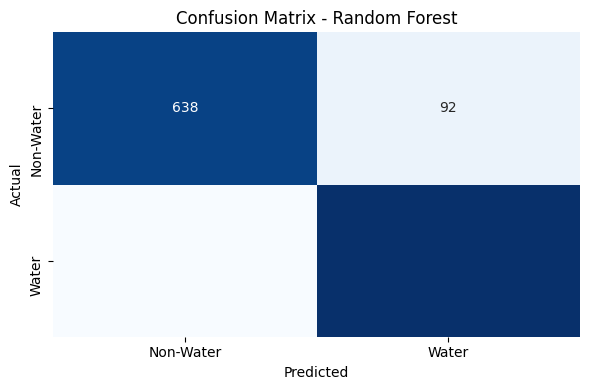

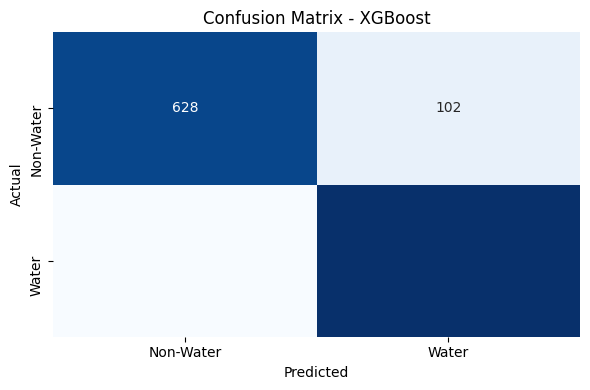

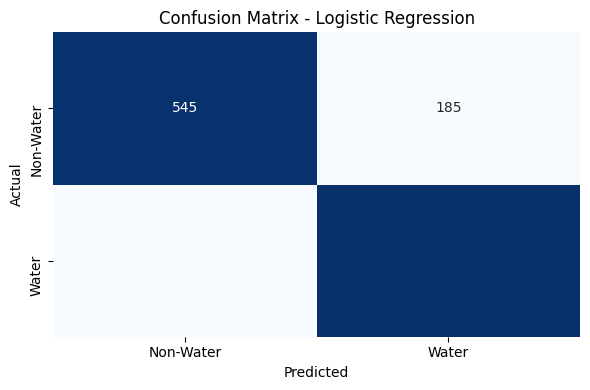

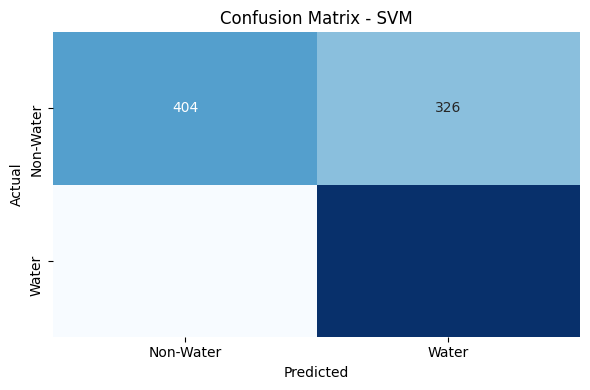

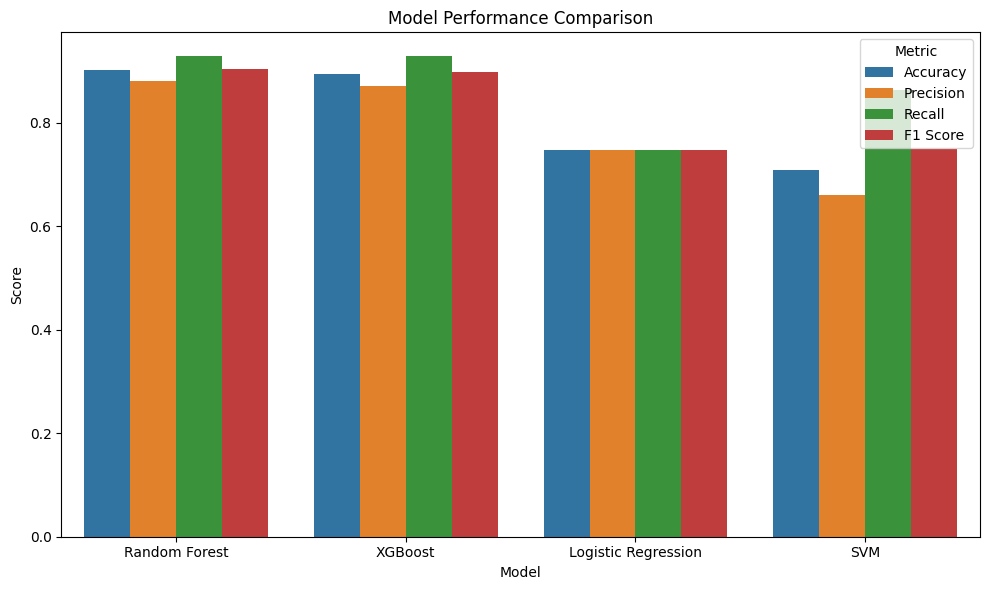


Model Performance Metrics:
                 Model  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.900956   0.880983  0.927793  0.903782
1              XGBoost  0.894126   0.869732  0.927793  0.897825
2  Logistic Regression  0.746585   0.747613  0.746594  0.747103
3                  SVM  0.709016   0.660417  0.863760  0.748524

Best Model (based on F1 Score): Random Forest with F1 Score: 0.9038


In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data (replace file paths with your actual paths)
df_train = pd.read_csv('Outputs/training_samples.csv')
df_test = pd.read_csv('Outputs/testing_samples.csv')

# Features and target (corrected column names)
features = ['VH', 'VH_VV_ratio', 'VV', 'mndwi', 'ndvi']
X_train = df_train[features]
y_train = df_train['Class']
X_test = df_test[features]
y_test = df_test['Class']

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42)
}

# Dictionary to store metrics
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Train and evaluate models
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store metrics
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(accuracy)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Water', 'Water'], yticklabels=['Non-Water', 'Water'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot bar chart for metrics comparison
metrics_melted = metrics_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_melted)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Print metrics table
print("\nModel Performance Metrics:")
print(metrics_df)

# Identify best model based on F1 Score
best_model = metrics_df.loc[metrics_df['F1 Score'].idxmax()]
print(f"\nBest Model (based on F1 Score): {best_model['Model']} with F1 Score: {best_model['F1 Score']:.4f}")